# Player Ratings and Substitution Models

This notebook will generate player ratings based on the xGBoost algorithm and then use those in two proposed substitution models.

In [1]:
import pandas as pd # data manipulation\n",
pd.options.mode.chained_assignment = None  # default='warn'\n",
import numpy as np #  mathematical support for large, multi-dimensional arrays and matrices\n",
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import re
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

import collections
from matplotlib.patches import Arc
import math
#import xgboost
#import dtreeviz
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:

## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

# allDone()


### Set Directory

In [3]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/Players')
except:
    pass

In [4]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/matches/')
except:
    pass
os.listdir()

['matches_World_Cup.json',
 'matches_Italy.json',
 'matches_Germany.json',
 'matches_England.json',
 'matches_France.json',
 'matches_Spain.json',
 'matches_European_Championship.json']

In [5]:
England = pd.read_json('matches_England.json')
France = pd.read_json('matches_France.json')
Italy = pd.read_json('matches_Italy.json')
Spain = pd.read_json('matches_Spain.json')
Germany = pd.read_json('matches_Germany.json')

England['Country'] = 'England'
France['Country'] = 'France'
Italy['Country'] = 'Italy'
Spain['Country'] = 'Spain'
Germany['Country'] = "Germany"

In [6]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/')
except:
    pass

Teams = pd.read_json('teams.json')
Players = pd.read_json('players.json')

In [7]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/events/')
except:
    pass


### Data Cleaning

In [8]:
Matches = pd.concat([England, France, Italy, Spain, Germany], ignore_index=True)

In [9]:
Matches.drop(['duration'], inplace=True, axis =1) # removing groupName variable from World Cups

In [10]:
Players.drop(["passportArea"], inplace = True, axis = 1)

In [11]:
Players = Players.rename(columns ={'wyId': 'playerId'}) # rename for convenience

In [12]:
Teams = Teams.rename(columns = {'wyId': 'teamId'})
Players = Players.rename(columns = {'currentTeamId': 'teamId'})
Players = pd.merge(Players,Teams[['teamId', 'officialName']], on = 'teamId').rename(columns = {'officialName': 'clubName'})

In [13]:
Players['Position'] = Players.role.apply(pd.Series)['code3'].values

In [14]:
Players['birthCountry'] = Players.birthArea.apply(pd.Series)['name'].values

In [15]:
Players.drop(["birthArea", 'role'], inplace = True, axis = 1)

### Manipulate Match Data

In [16]:
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match

In [17]:
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match
homeTeam, awayTeam = [],[]
for x in teams:
    homeTeam.append(x[0])
    awayTeam.append(x[1])

In [18]:
# add columns for additional match statistics
Matches["homeManagerId"] = None
for name in ["Score", "ScoreHT", "ScoreET", "ScoreP"]:
    colname = "home" + name
    colname2 = "away" + name
    Matches[colname] = None
    Matches[colname2] = None

In [19]:
# parse Home and Away teams as features from nest dictionary
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match
homeTeam, awayTeam = [],[]
for game, team in enumerate(teams):
    if Matches.teamsData[game:game+1][game][team[0]]['side'] == 'home':
        homeTeam.append(team[0])
        awayTeam.append(team[1])
    else:
        awayTeam.append(team[0])
        homeTeam.append(team[1])

In [20]:
def get_team_stats(df, team): # function to parse team match stats from dictionary embedded in column teamsData from the Matches dataframe
    
    Bench, Starters, Manager, Score, ScoreHT, ScoreET, ScoreP, teamId = [],[],[],[],[],[],[],[]
    
    for game in range(0, len(df)):

        Bench.append(list(pd.DataFrame.from_dict(df.teamsData[game][team[game]]['formation']['bench'])['playerId']))
        Starters.append(list(pd.DataFrame.from_dict(df.teamsData[game][team[game]]['formation']['lineup'])['playerId']))
        Manager.append(df.teamsData[game][team[game]]['coachId'])
        Score.append(df.teamsData[game][team[game]]['score'])
        ScoreHT.append(df.teamsData[game][team[game]]['scoreHT'])
        ScoreET.append(df.teamsData[game][team[game]]['scoreET'])
        ScoreP.append(df.teamsData[game][team[game]]['scoreP'])
        teamId.append(df.teamsData[game][team[game]]['teamId'])
    
    return Bench, Starters, Manager, Score, ScoreHT, ScoreET, ScoreP, teamId

homeBench, homeStarters, homeManager, homeScore, homeScoreHT, homeScoreET, homeScoreP, homeTeamId = get_team_stats(Matches, homeTeam)
awayBench, awayStarters, awayManager, awayScore, awayScoreHT, awayScoreET, awayScoreP, awayTeamId = get_team_stats(Matches, awayTeam)


In [21]:
# Automating Bench Line Up Column Generation

homeColNames = []
for num in range(1,14): # add columns for home bench playerId
     homeColNames.append("homeBenchPlayer" + str(num))
        
awayColNames = []
for num in range(1,14): # add columns for away bench playerId
    awayColNames.append("awayBenchPlayer" + str(num))
    


In [22]:
# Inspecting bench counts as during errror handling reveals some matches had bench sizes of between 8 and 13 for certain fixtures
import collections
collections.Counter(list(map(lambda x: len(x), homeBench)))

Counter({7: 1425, 6: 18, 5: 1, 8: 5, 12: 205, 10: 49, 11: 101, 9: 21, 13: 1})

In [23]:
# Adding Bench Line Ups to DataFrame

homeBench2 = pd.DataFrame(homeBench,
     columns=homeColNames)
awayBench2 = pd.DataFrame(awayBench,
     columns=awayColNames)


In [24]:
# Automating Starting Line Up Column Generation

homeColNames =[]
for num in range(1,12): # add columns for starting playerId
     homeColNames.append("homePlayer" + str(num))
        
awayColNames = []
for num in range(1,12): # add columns for starting playerId
    awayColNames.append("awayPlayer" + str(num))


In [25]:
# Joining starting line ups, benches to matches dataframe

homeStarters2 = pd.DataFrame(homeStarters,
     columns=homeColNames)
awayStarters2 = pd.DataFrame(awayStarters,
     columns=awayColNames)

Matches = Matches.join([homeStarters2, awayStarters2, homeBench2, awayBench2])


In [26]:
# add individual columns of match data
Matches['homeManager'] = homeManager
Matches['homeScore'] = homeScore
Matches['homeScoreHT'] = homeScoreHT
Matches['homeScoreET'] = homeScoreET
Matches['homeScoreP'] = homeScoreP
Matches['homeTeamId'] = homeTeamId
Matches['awayManager'] = awayManager
Matches['awayScore'] = awayScore
Matches['awayScoreHT'] = awayScoreHT
Matches['awayScoreET'] = awayScoreET
Matches['awayScoreP'] = awayScoreP
Matches['awayTeamId'] = awayTeamId

In [27]:
Matches.drop(["teamsData"], inplace = True, axis = 1)

In [28]:
# Classify Match Result as W, L or D for teams
conditions = [
    (Matches['winner'] == 0),
    (Matches['winner'] == Matches['awayTeamId']),
    (Matches['winner'] == Matches['homeTeamId'])
    ]

# create a list of the values we want to assign for each condition
values = [0, -1, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
Matches['Result'] = np.select(conditions, values)

In [29]:
Matches["date"] = pd.to_datetime(Matches['dateutc']).dt.date # create a date column for Matches dataframe

In [30]:
Matches["time"] = pd.to_datetime(Matches['dateutc']).dt.time # create a time column for Matches dataframe

In [31]:
# Prelim Dimensionality Reduction
cols2Drop = ['status', 'roundId', 'gameweek', 'dateutc', 'label', 'referees', 'homeManagerId', 'seasonId']
Matches.drop(cols2Drop, inplace=True, axis =1)
Matches.drop(['winner', 'date', 'time'], inplace = True, axis =1)

In [32]:
Matches.rename(columns={'wyId':'matchId'}, inplace=True)

In [33]:
Matches = Matches.fillna(0) # fill bench7players with Ids = 0 in order to prevent program crashing

### Player Aggs

In [34]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/New_Player_Aggs_live')

In [35]:
# path = os.getcwd()

Player_Aggs_live10 = pd.read_csv('Player_Aggs_live10')
Player_Aggs_live10.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live20= pd.read_csv('Player_Aggs_live20')
Player_Aggs_live20.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live30= pd.read_csv('Player_Aggs_live30')
Player_Aggs_live30.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live40= pd.read_csv('Player_Aggs_live40')
Player_Aggs_live40.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live50= pd.read_csv('Player_Aggs_live50')
Player_Aggs_live50.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live60= pd.read_csv('Player_Aggs_live60')
Player_Aggs_live60.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live70= pd.read_csv('Player_Aggs_live70')
Player_Aggs_live70.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live80= pd.read_csv('Player_Aggs_live80')
Player_Aggs_live80.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live90= pd.read_csv('Player_Aggs_live90')
Player_Aggs_live90.drop(["Unnamed: 0"], axis=1, inplace=True)

In [36]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/')

Met_Aggs_live10 = pd.read_json('MetAggs/Met_live_10')
Met_Aggs_live20 = pd.read_json('MetAggs/Met_live_20')
Met_Aggs_live30 = pd.read_json('MetAggs/Met_live_30')
Met_Aggs_live40 = pd.read_json('MetAggs/Met_live_40')
Met_Aggs_live50 = pd.read_json('MetAggs/Met_live_50')
Met_Aggs_live60 = pd.read_json('MetAggs/Met_live_60')
Met_Aggs_live70 = pd.read_json('MetAggs/Met_live_70')
Met_Aggs_live80 = pd.read_json('MetAggs/Met_live_80')
Met_Aggs_live90 = pd.read_json('MetAggs/Met_live_90')

In [37]:
Aggs10 = pd.merge(Player_Aggs_live10, Met_Aggs_live10, how = 'left', on = ['matchId','playerId','teamId'])
Aggs20 = pd.merge(Player_Aggs_live20, Met_Aggs_live20, how = 'left', on = ['matchId','playerId','teamId'])
Aggs30 = pd.merge(Player_Aggs_live30, Met_Aggs_live30, how = 'left', on = ['matchId','playerId','teamId'])
Aggs40 = pd.merge(Player_Aggs_live40, Met_Aggs_live40, how = 'left', on = ['matchId','playerId','teamId'])
Aggs50 = pd.merge(Player_Aggs_live50, Met_Aggs_live50, how = 'left', on = ['matchId','playerId','teamId'])
Aggs60 = pd.merge(Player_Aggs_live60, Met_Aggs_live60, how = 'left', on = ['matchId','playerId','teamId'])
Aggs70 = pd.merge(Player_Aggs_live70, Met_Aggs_live70, how = 'left', on = ['matchId','playerId','teamId'])
Aggs80 = pd.merge(Player_Aggs_live80, Met_Aggs_live80, how = 'left', on = ['matchId','playerId','teamId'])
Aggs90 = pd.merge(Player_Aggs_live90, Met_Aggs_live90, how = 'left', on = ['matchId','playerId','teamId'])

In [38]:
def Matches_df_fDNN(TAM):
    df2 = TAM.groupby('matchId').agg(list).reset_index()
    df2.drop(["Result","homeTeamId", "awayTeamId", "height", "weight", 'playerId', "xStart", "yStart", "gameTime (min)"], inplace=True, axis=1)

    df4 = pd.concat([df2, pd.DataFrame(df2['teamId'].to_list(), columns=['team1','team2'])], axis=1, sort = False)
    df4.drop(["teamId"], inplace=True, axis = 1)
    result = pd.merge(df4, Matches[['matchId', "homeTeamId", "awayTeamId"]], on='matchId', how='inner')


    df3 = result.iloc[:,-4:]
    for var in list(result.columns)[1:-4]:

        df3 = pd.concat([df3, pd.DataFrame(result[var].to_list(), columns=["1_" + var, "2_" + var])], axis=1, sort = False)

        # Correctly apply allocate home and away aggregate statistics to correct teams
        df3['home'+var] = (
            np.select(
                condlist=[result['team1'] == result['homeTeamId'], result['team2'] == result['homeTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        df3['away'+var] = (
            np.select(
                condlist=[result['team1'] == result['awayTeamId'], result['team2'] == result['awayTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        # # drop useless columns that have been replaced
        df3.drop([ "1_" + var, "2_" + var], inplace = True, axis = 1 )

    df3 = pd.concat([result[['matchId']],df3], axis=1)
    df3 = pd.merge(df3, Matches[["matchId", "Result"]], how ="inner", on='matchId')
    df3.drop(["team1", "team2"], axis=1, inplace=True)

    return df3


## Generate a DF of Subs & Bench for each Game

In [39]:
allmatches = pd.concat([England, France, Italy, Spain, Germany], ignore_index=True)

In [40]:
matchids = list(allmatches['wyId'])

In [41]:
allteamsdata = list(allmatches['teamsData'])
matchids = list(allmatches['wyId'])

subs = []
for i in range(len(allteamsdata)):
    teams = allteamsdata[i].keys()
    for team in teams:
        for item in allteamsdata[i][team]['formation']['substitutions']:
            s = []
            s.append(matchids[i])
            s.append(team)
            try:
                s.append(item['playerIn'])
                s.append(item['playerOut'])
                s.append(item['minute'])
            except:
                pass
                #print(item, team, matchids[i])
            subs.append(s)

Sub = pd.DataFrame(subs, columns = ['matchId','teamId','playerIn','playerOut','minutes'])

In [42]:
Sub

,matchId,teamId,playerIn,playerOut,minutes
0,2500089,1646,9127.0,9206.0,61.0
1,2500089,1646,9179.0,93.0,80.0
2,2500089,1646,532949.0,8284.0,94.0
3,2500089,1659,7989.0,259531.0,59.0
4,2500089,1659,11669.0,245813.0,59.0
...,...,...,...,...,...
10442,2516739,2446,49859.0,14803.0,46.0
10443,2516739,2446,16110.0,89559.0,61.0
10444,2516739,2444,14727.0,14732.0,61.0
10445,2516739,2444,14718.0,14795.0,62.0


In [43]:
bench = []
for i in range(len(allteamsdata)):
    teams = allteamsdata[i].keys()
    for team in teams:
        for item in allteamsdata[i][team]['formation']['bench']:
            b = []
            b.append(matchids[i])
            b.append(team)
            try:
                b.append(item['playerId'])
            except:
                pass
                #print(item, team, matchids[i])
            bench.append(b)

Bench = pd.DataFrame(bench, columns = ['matchId','teamId','playerId'])

In [44]:
Bench

,matchId,teamId,playerId
0,2500089,1646,77502
1,2500089,1646,270828
2,2500089,1646,9164
3,2500089,1646,8516
4,2500089,1646,9179
...,...,...,...
28710,2516739,2444,272285
28711,2516739,2444,258162
28712,2516739,2444,14727
28713,2516739,2444,231139


### Team Tactics and Automated Subs / Formation Shifts

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from random import seed
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D

In [46]:
from sklearn import preprocessing
from numpy import mean
from numpy import std

In [47]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [48]:
def Matches_df_fDNN(TAM):
    df2 = TAM.groupby('matchId').agg(list).reset_index()
    df2.drop(["Result","homeTeamId", "awayTeamId", "height", "weight", 'playerId', "xStart", "yStart", "gameTime (min)"], inplace=True, axis=1)

    df4 = pd.concat([df2, pd.DataFrame(df2['teamId'].to_list(), columns=['team1','team2'])], axis=1, sort = False)
    df4.drop(["teamId"], inplace=True, axis = 1)
    result = pd.merge(df4, Matches[['matchId', "homeTeamId", "awayTeamId"]], on='matchId', how='inner')


    df3 = result.iloc[:,-4:]
    for var in list(result.columns)[1:-4]:

        df3 = pd.concat([df3, pd.DataFrame(result[var].to_list(), columns=["1_" + var, "2_" + var])], axis=1, sort = False)

        # Correctly apply allocate home and away aggregate statistics to correct teams
        df3['home'+var] = (
            np.select(
                condlist=[result['team1'] == result['homeTeamId'], result['team2'] == result['homeTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        df3['away'+var] = (
            np.select(
                condlist=[result['team1'] == result['awayTeamId'], result['team2'] == result['awayTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        # # drop useless columns that have been replaced
        df3.drop([ "1_" + var, "2_" + var], inplace = True, axis = 1 )

    df3 = pd.concat([result[['matchId']],df3], axis=1)
    df3 = pd.merge(df3, Matches[["matchId", "Result"]], how ="inner", on='matchId')
    df3.drop(["team1", "team2"], axis=1, inplace=True)

    return df3


In [49]:
def team_result(team_df):
    
    df = pd.merge(team_df, Matches[["homeTeamId", "awayTeamId","matchId", "Result"]], how = "left", on = ["matchId"])
    
    # Classify Match W, L or D for a team
    conditions = [
        ((df['homeTeamId'] == df.teamId)&(df.Result== 1)),
        ((df['homeTeamId'] == df.teamId)&(df.Result== 0)),
        ((df['homeTeamId'] == df.teamId)&(df.Result==-1)),
        ((df['awayTeamId'] == df.teamId)&(df.Result== 1)),
        ((df['awayTeamId'] == df.teamId)&(df.Result== 0)),
        ((df['awayTeamId'] == df.teamId)&(df.Result==-1))
        ]

    # create a list of the values we want to assign for each condition
    values = [1,0,-1,-1,0,1]

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['result'] = np.select(conditions, values)
    df.drop(["Result"], axis=1,inplace=True)
    return df

Use one of the next two cells to create the test data- unsure which one makes more sense

In [50]:
# Team_Aggs_Matches = Aggs90.groupby(['matchId', 'teamId' ]).sum().reset_index()
# Team_Aggs_Matches = pd.merge(Team_Aggs_Matches, Matches[['matchId', "Result"]], how = 'left', on = 'matchId' )
# result = Matches_df_fDNN(Team_Aggs_Matches)

# X_all = result.loc[:, ~result.columns.isin(["Result",'teamId', 'matchId', 'homeTeamId', 'awayTeamId', 'gameTime (min)'])]
# y_all = result["Result"].values
# X_all = X_all.replace([np.inf, -np.inf], np.nan)
# X_all = X_all.fillna(X_all.mean())
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)

In [51]:
team_tactics = Aggs90.groupby(['matchId', 'teamId']).sum().reset_index()
team_tactics.drop(["playerId", 'weight', 'height', 'xStart', 'yStart', 'homeTeamId', 'awayTeamId', 'gameTime (min)' ], axis = 1, inplace = True)

df = team_result(team_tactics)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)
df = df.loc[:, (df != 0).any(axis=0)]
df.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)
X_all = df.iloc[:,2:-1]
y_all = df.result.values
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)



### Trying to get feature importances from xGBoost and see how it changes player ratings

In [52]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [53]:
import datetime
from datetime import *

In [54]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [55]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.0001,0.001, 0.01, 0.02,0.1, 0.2, 0.3],
        'n_estimators': [100,200,500,1000]
        }

In [56]:
##### CREATE XGB WITH OPTIMIZED PARAMS
# Best hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 1.5, 'colsample_bytree': 0.8}

xgb = XGBClassifier(features_names=X_all.columns, gamma=1.5, n_estimators =500, max_depth=7, min_child_weight=5)
xgb.fit(X_train, y_train)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "features_names" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:53:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              features_names=Index(['AccBackMetres_ZoneS_1', 'AccBackMetres_ZoneS_2',
       'AccBackMetres_ZoneS_3', 'AccBackMetres_ZoneS_4',
       'AccBackMetres_ZoneS_5', 'AccBackMetres_ZoneS_6',
       'AccBackMetres_ZoneS_7', 'AccBackMetres_ZoneS_8',
       'AccBac...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [57]:
# make predictions for test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 60.05%


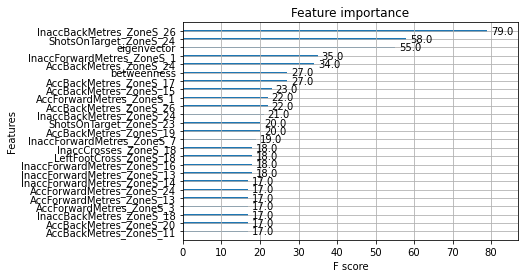

<Figure size 360x360 with 0 Axes>

In [58]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb, max_num_features=25, ylabel="Features")
plt.figure(figsize=(5,5))
#fig.set_size_inches(6.5, 4.5, forward=True)
plt.show()

In [59]:
### Determing player ratings for feature importance

df1 = Aggs90.iloc[:,:15]
df2 = Aggs90.iloc[:,15:]
#df2 = result.iloc[:,3:-1]
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.fillna(0)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df2.values)
df2 = pd.DataFrame(x_scaled, columns = df2.columns)

#base_imp = imp_df(df2.columns, rf.feature_importances_)
base_imp = imp_df(df2.columns, xgb.feature_importances_)
xxx = base_imp.transpose()
xxx.columns = xxx.iloc[0]
xxx = xxx.drop(xxx.index[[0]])
xxx = xxx.reindex(sorted(xxx.columns), axis=1)
df2 = df2.reindex(sorted(df2.columns), axis=1)
df2 = df2.multiply(xxx.values)
negatives = df2.filter(regex='Inacc|Lost|Fouls|Fail|Not|Leaving').columns
df2[negatives] = df2[negatives].multiply(-1)
df2["sum"] = df2.iloc[:,:-1].sum(axis=1)
df2 = pd.concat([df1, df2], axis=1)
df2 = pd.merge(df2, df[["matchId", 'teamId', "result"]], on =['matchId', "teamId"], how = 'left' )
#df2 = df2.loc[:, (df2 != 0).any(axis=0)]
df2['playerRatings']=  np.where(df2['gameTime (min)'] ==0, 0, df2['sum'])
df2['playerRatings'] = df2['playerRatings'].multiply(94 / float(df2.playerRatings.nlargest(5)[-1:]))
df2['playerRatings'] = np.where(df2['playerRatings'] > 94.0, 94, df2['playerRatings'])
df2.drop(["sum"], axis=1, inplace=True)
collections.Counter(df2.sort_values("playerRatings", ascending=False).iloc[0:100,:].Position)

Counter({'FWD': 38, 'MID': 50, 'DEF': 9, nan: 3})

In [60]:
df2.sort_values("playerRatings", ascending=False).iloc[0:10,:]

,shortName,Position,playerId,weight,height,foot,matchId,xStart,yStart,teamId,...,dangerousOwnHalfBallLost_ZoneS_5,dangerousOwnHalfBallLost_ZoneS_6,dangerousOwnHalfBallLost_ZoneS_7,dangerousOwnHalfBallLost_ZoneS_8,dangerousOwnHalfBallLost_ZoneS_9,eigenvector,entropy,outdegree,result,playerRatings
17318,Neymar,FWD,40810,68.0,175.0,right,2500700,68.141892,38.331081,3767,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001984,0.001736,0.001293,1,94.000000
40682,L. Insigne,FWD,21385,59.0,163.0,right,2576226,70.364583,22.520833,3187,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001709,0.001537,0.001411,-1,94.000000
30936,T. Kroos,MID,14723,76.0,183.0,right,2565733,60.750000,30.395161,675,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001911,0.001619,0.001293,-1,94.000000
22202,K. Coman,FWD,231139,71.0,178.0,right,2516856,66.977528,26.730337,2444,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001454,0.001566,0.001293,1,94.000000
665,M. \u00d6zil,MID,3319,76.0,180.0,left,2499960,66.742647,47.948529,1609,...,-0.0,-0.0,-0.0,-0.0,-0.000111,0.001764,0.001774,0.001411,-1,94.000000
20845,R. Cabella,MID,25999,68.0,171.0,right,2501024,61.262411,42.255319,3782,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001961,0.001814,0.001646,1,93.115239
20205,Neymar,FWD,40810,68.0,175.0,right,2500862,67.222222,29.325397,3767,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001597,0.001669,0.001411,1,91.954661
38820,L. Messi,FWD,3359,72.0,170.0,left,2565615,76.083333,60.875000,676,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001722,0.001747,0.001411,1,90.869050
39064,L. Messi,FWD,3359,72.0,170.0,left,2565889,73.387387,61.891892,676,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001796,0.001585,0.001293,1,90.527129
45487,M. Ham\u0161\u00edk,MID,21171,79.0,183.0,right,2575994,58.733333,20.248485,3187,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001657,0.001538,0.001293,1,90.312835


In [61]:
player_values = df2.sort_values("playerRatings", ascending=False)

In [62]:
test = player_values.groupby(["shortName", 'playerId', "teamId", "Position"]).sum().reset_index().sort_values("playerRatings", ascending=False)



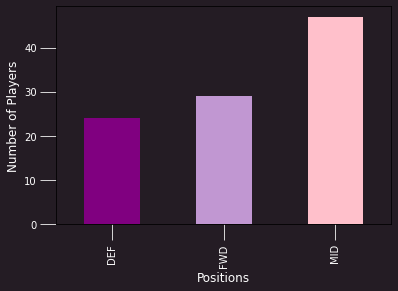

In [63]:
colors = ['purple','#c197d2','pink'] #navy
fig =plt.figure()
ax = test.head(100).groupby('Position')["playerRatings"].nunique().plot(kind='bar',  color=colors, )
ax.patch.set_facecolor('#241C24')
fig.patch.set_facecolor('#241C24')
ax.tick_params(axis='x', colors='white',size =16 )
ax.tick_params(axis='y', colors='white', size=16)
plt.ylabel("Number of Players", color = "white", size = 12)
plt.xlabel("Positions", color = "white", size=12)
plt.show()


In [64]:
test["PR_perMatch"] = 100*test["playerRatings"] / test["gameTime (min)"] 

In [65]:
test["PR_perMatch"] = test["PR_perMatch"].multiply(94 / float(test.PR_perMatch.max()))# normalize player ratings per match


In [66]:
test.sort_values("playerRatings", ascending=False).round(1).head()#[["Name", "Position", "Mins Played", "playerRatings"]].head(5)

,shortName,playerId,teamId,Position,weight,height,matchId,xStart,yStart,homeTeamId,awayTeamId,gameTime (min),result,playerRatings,PR_perMatch
1323,L. Messi,3359,676,FWD,2592.0,6120.0,92366299,2429.8,2033.4,24620,24646,3240.0,27,2240.6,93.1
1201,K. De Bruyne,38021,1625,MID,2516.0,6697.0,92496510,2304.1,2076.1,69133,69107,3330.0,29,2004.0,81.0
1310,L. Insigne,21385,3187,FWD,2183.0,6031.0,95317567,2412.0,748.5,117849,117860,3330.0,25,1980.0,80.0
1463,M. Ham\u0161\u00edk,21171,3187,MID,3002.0,6954.0,97893682,2177.0,1097.5,121036,121036,3420.0,25,1887.6,74.3
940,Illarramendi,3676,687,MID,2700.0,6444.0,92366533,1684.3,1974.6,24811,24753,3240.0,-3,1883.3,78.2


In [67]:
top_per_game = test.sort_values("PR_perMatch", ascending=False).round(1)
top_per_game = top_per_game.loc[top_per_game['gameTime (min)'] >= 1000]
top_per_game.head(5)

,shortName,playerId,teamId,Position,weight,height,matchId,xStart,yStart,homeTeamId,awayTeamId,gameTime (min),result,playerRatings,PR_perMatch
1323,L. Messi,3359,676,FWD,2592.0,6120.0,92366299,2429.8,2033.4,24620,24646,3240.0,27,2240.6,93.1
2184,T. Kroos,14723,675,MID,2052.0,4941.0,69274745,1471.8,933.1,18408,18485,2430.0,9,1659.1,91.9
1712,Neymar,40810,3767,FWD,1360.0,3500.0,50016519,1308.9,655.1,91513,75492,1800.0,17,1211.7,90.6
572,David Silva,8317,1625,MID,1943.0,5017.0,72496709,1792.2,1218.6,56132,56102,2610.0,25,1686.3,86.9
443,Cristiano Ronaldo,3322,675,FWD,2241.0,5049.0,69274871,1948.9,1168.5,18436,18482,2430.0,11,1521.8,84.3


# Building the Substitution Model

## Model 1

1. Taking a game at 60 mins, develop the player rating of all players based on feature importance from the fitted xGB model.
2. Using an xGB fitted again on the 60 min game, predict the probability of each outcome for the team (ie lose, draw, win).
3. Find the lowest ranked player who is not a keeper. 
4. Then take that team's bench, look at the players' attributes for all the other games they played (per min).
5. Then iterate the xgb probability prediction based on the proposed sub's expected performance.
6. Recommend a sub based on the best win/draw outcome.

In [68]:
# The way that Player_Aggs_liveXX is created means it dumps any columns that don't have data.
# This means that if we want to use the feature importances for player rankings on the xGB fitted for Aggs90,
# we need to make sure that Aggs60 and Aggs90 have the exact same columns in the exact same order.
# It ain't pretty, but this chunk of code does that 
Aggs61 = Aggs60.copy()

col90 = list(Aggs90.columns)
col60 = list(Aggs60.columns)

for i in range(len(col90)):
    item = col90[i]
    if item not in col60:
        #print(i)
        Aggs61.insert(i,item,[np.nan]*50518)
        
ll  = list(Aggs61.columns)
lk = list(Aggs90.columns)

for i in range(len(ll)):
    if ll[i] != lk[i]:
        #print(ll[i], lk[i], i)
        column = Aggs61.pop(ll[i])
        Aggs61.insert(lk.index(ll[i]), ll[i], column)
        
ll  = list(Aggs61.columns)
lk = list(Aggs90.columns)
ll == lk

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


True

In [69]:
Aggs60 = Aggs61
Aggs60 = Aggs60.fillna(0)

In [194]:
### Determining player ratings from feature importance

df1 = Aggs60.iloc[:,:15]
df2 = Aggs60.iloc[:,15:]
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.fillna(0)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df2.values)
df2 = pd.DataFrame(x_scaled, columns = df2.columns)

#base_imp = imp_df(df2.columns, rf.feature_importances_)
base_imp = imp_df(df2.columns, xgb.feature_importances_)
xxx = base_imp.transpose()
xxx.columns = xxx.iloc[0]
xxx = xxx.drop(xxx.index[[0]])
xxx = xxx.reindex(sorted(xxx.columns), axis=1)
df2 = df2.reindex(sorted(df2.columns), axis=1)
df2 = df2.multiply(xxx.values)
negatives = df2.filter(regex='Inacc|Lost|Fouls|Fail|Not|Leaving').columns
df2[negatives] = df2[negatives].multiply(-1)
df2["sum"] = df2.iloc[:,:-1].sum(axis=1)
df2 = pd.concat([df1, df2], axis=1)
df2 = pd.merge(df2, df[["matchId", 'teamId', "result"]], on =['matchId', "teamId"], how = 'left' )
#df2 = df2.loc[:, (df2 != 0).any(axis=0)]
df2['playerRatings']=  np.where(df2['gameTime (min)'] ==0, 0, df2['sum'])
df2['playerRatings'] = df2['playerRatings'].multiply(94 / float(df2.playerRatings.nlargest(5)[-1:]))
df2['playerRatings'] = np.where(df2['playerRatings'] > 94.0, 94, df2['playerRatings'])
df2.drop(["sum"], axis=1, inplace=True)
#collections.Counter(df2.sort_values("playerRatings", ascending=False).iloc[0:100,:].Position)

In [195]:
# player_rat_60 is the player rating after 60 minutes of play time based on feature importances from the 90min model.
player_rat_60 = df2

In [72]:
# Fit the xGB model on the 60 min portion of the game (this will be used for win probabilities)
team_tactics = Aggs60.groupby(['matchId', 'teamId']).sum().reset_index()
team_tactics.drop(["playerId", 'weight', 'height', 'xStart', 'yStart', 'homeTeamId', 'awayTeamId', 'gameTime (min)' ], axis = 1, inplace = True)

df = team_result(team_tactics)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

#df = df.loc[:, (df != 0).any(axis=0)]

df.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)

# Take out game of interest here
FCB_RM = df.loc[df['matchId'] == 2565711].iloc[:,:-1]
df = df.loc[df['matchId'] != 2565711]

X_all = df.iloc[:,:-1]
y_all = df.result.values

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, 
                                                    random_state=3)

matid_train = X_train
X_train = X_train.iloc[:,2:]

#matid_test = X_test
matid_test = pd.concat([X_test,FCB_RM],axis = 0)
X_test = X_test.iloc[:,2:]


In [73]:
xgb = XGBClassifier(features_names=X_all.columns, gamma=1.5, n_estimators =500, max_depth=7, min_child_weight=5,
                   tree_method = 'hist')
xgb.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "features_names" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:24:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              features_names=Index(['matchId', 'teamId', 'AccBackMetres_ZoneS_1', 'AccBackMetres_ZoneS_2',
       'AccBackMetres_ZoneS_3', 'AccBackMetres_ZoneS_4',
       'AccBackMetres_ZoneS_5', 'AccBackMetres_ZoneS_6',
       'AccBackMetres_ZoneS_7', 'AccBackMetr...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='hist', validate_parameters=1,
              verbosity=None)

In [74]:
def take_out_subs(Aggs, Sub, matchid):
    # This function takes out the subs from the Aggs / player_rat_60 dataframe so we don't accidentally consider them
    # As needing substitution.
    
    subsin = list(Sub.loc[Sub['matchId']== matchid]['playerIn'])
    
    mat60 = Aggs.loc[Aggs['matchId']  == matchid]
    Aggs = Aggs.loc[Aggs['matchId'] != matchid]

    for s in subsin:
        mat60 = mat60.loc[mat60['playerId'] != s]
        
    Aggs = pd.concat([Aggs,mat60])
    
    return Aggs

In [75]:
def one_game_withdrawal(Aggs,match,teamid):
    team_tactics = Aggs.groupby(['matchId', 'teamId']).sum().reset_index()
    team_tactics.drop(["playerId", 'weight', 'height', 'xStart', 'yStart', 'homeTeamId', 'awayTeamId', 'gameTime (min)' ], axis = 1, inplace = True)
    
    df = team_result(team_tactics)

    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    
    #df = df.loc[:, (df != 0).any(axis=0)]
    
    df.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)
    
    notgame = df.loc[df['matchId']!= match]
    game = df.loc[df['matchId'] == int(match)]
    game = game.loc[game['teamId'] == int(teamid)]
    
    X_train = notgame.iloc[:,2:-1]
    y_train = notgame.result.values
    #X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)
    X_test = game.iloc[:,2:-1]
    y_test = game.result.values
    
    return X_test

In [76]:
def changeplayer(Aggs, matchid, teamid, playerid, average, ids):
    
    Aggs = Aggs.loc[Aggs['matchId'] == matchid]
    Aggs = Aggs.loc[Aggs['teamId'] == teamid]
    
    Aggs = Aggs.loc[Aggs['playerId'] != playerid]

    temp = pd.DataFrame(average)
    temp = temp.transpose()
    
    ids = ids.reset_index().iloc[:,1:]
    
    temp = pd.concat([ids,temp],axis =1)
    
    temp['matchId'] = matchid
    
    Aggs = pd.concat([Aggs,temp], ignore_index = True)
    
    return Aggs

In [77]:
Players = pd.read_json('/Users/Yuval/Desktop/Pawsey/data/players.json')

### Model 1- Specific game

Specify a game and a team and have the model evaluate best substitution.

In [78]:
# 3-0 el classico - 2565711
# 2-2 el classico - 2565907
# Valencia Barca draw 2565672 in X_test
# Barca Valencia 2-1 win 2565858 in X_test

In [79]:
matchid = 2565711
teamid = 676

In [80]:
# Take out subs
Aggs60 = take_out_subs(Aggs60, Sub, matchid)
player_rat_60 = take_out_subs(player_rat_60, Sub, matchid)

# inspecting player performance in a specific match for automated tactical sub recommendations (underperforming players)
gamerat = player_rat_60[player_rat_60.matchId==matchid].sort_values("playerRatings", ascending=False)

#teamid = list(matid_test.loc[matid_test['matchId'] == matchid]['teamId'])[1]

specific_bench = Bench.loc[Bench['matchId']==matchid]
specific_bench = specific_bench.loc[specific_bench['teamId'] == str(teamid)]

potentials = list(specific_bench['playerId'])

ratings = []
for pot in potentials:
    try:
        ratings.append(list(test.loc[test['playerId'] == pot]['PR_perMatch'])[0]*2/3) # 60 mins
    except:
        ratings.append(0) # Player is not in Players DB - maybe has never played? CHECK THIS
        
positions = []
for pot in potentials:
    try:
        positions.append(Players.loc[Players['wyId'] == pot]['role'].iloc[0]['code3'])
    except:
        positions.append('UNKNOWN')# Player is not in Players DB - maybe has never played?
        
playerId = list(gamerat.loc[(gamerat['teamId']==teamid) & (gamerat['Position'] != 'GKP')].iloc[-1:]['playerId'])[0]

pos = gamerat.loc[(gamerat['teamId']==teamid) & (gamerat['Position'] != 'GKP')].iloc[-1]['Position']

for p in range(len(potentials)):
    if positions[p] == 'GKP':
        pots = potentials[:p]+potentials[p+1:]
        poss = positions[:p]+positions[p+1:]
        rats = ratings[:p] + ratings[p+1:]
potentials = pots
positions = poss
ratings = rats

try:
    if np.isnan(pos):
        pos = Players.loc[Players['wyId'] == playerId]['role'].iloc[0]['code3']
except:
    pass




In [81]:
gamerat

,shortName,Position,playerId,weight,height,foot,matchId,xStart,yStart,teamId,...,dangerousOwnHalfBallLost_ZoneS_5,dangerousOwnHalfBallLost_ZoneS_6,dangerousOwnHalfBallLost_ZoneS_7,dangerousOwnHalfBallLost_ZoneS_8,dangerousOwnHalfBallLost_ZoneS_9,eigenvector,entropy,outdegree,result,playerRatings
38919,0,0,40550,0.0,0.0,0,2565711,54.013333,62.320000,676,...,-0.0,-0.0,-0.0,-0.000273,-0.0,0.00185,0.001673,0.001134,1,60.461617
38945,Cristiano Ronaldo,FWD,3322,83.0,187.0,right,2565711,71.833333,39.900000,675,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001523,0.001591,0.001134,-1,60.289528
38943,Marcelo,DEF,3310,80.0,174.0,left,2565711,56.915663,17.686747,675,...,-0.0,-0.000243,-0.0,-0.0,-0.0,0.001803,0.001656,0.00126,-1,55.680838
38923,L. Su\u00e1rez,FWD,7972,86.0,182.0,right,2565711,70.134615,44.634615,676,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001697,0.001689,0.001134,1,55.540971
38930,I. Rakiti\u0107,MID,3476,78.0,184.0,right,2565711,47.771084,55.457831,676,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001415,0.001637,0.001134,1,52.790360
38938,Daniel Carvajal,DEF,4501,73.0,173.0,right,2565711,51.096774,81.016129,675,...,-0.0,-0.0,-0.0,-0.000273,-0.000139,0.001964,0.001731,0.001512,-1,51.207097
38934,T. Kroos,MID,14723,76.0,183.0,right,2565711,56.428571,33.985714,675,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001871,0.001729,0.001386,-1,49.926995
38942,R. Varane,DEF,3309,81.0,191.0,right,2565711,31.896552,61.379310,675,...,-0.000432,-0.0,-0.0,-0.0,-0.0,0.001614,0.001646,0.001134,-1,49.774518
38937,Casemiro,MID,40756,84.0,185.0,right,2565711,40.403846,40.846154,675,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001365,0.001703,0.001134,-1,48.896609
38928,L. Messi,FWD,3359,72.0,170.0,left,2565711,66.636364,56.784091,676,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.001599,0.001647,0.001134,1,48.751342


In [82]:
game_test = one_game_withdrawal(Aggs60,matchid,teamid)

In [83]:
xgb_results = []
sco = xgb.predict_proba(game_test)
print(sco)
xgb_results.append(sco)

[[0.06921117 0.23717143 0.69361746]]


In [84]:
players = []
players.append(playerId)

for i in range(len(positions)):
    #if positions[i] == pos:
        
    proposed = potentials[i]
    players.append(proposed)
    temp = Aggs60.loc[Aggs60['playerId'] == proposed]
    ids = temp.iloc[0:1,:15]
    temp = temp.iloc[:,15:]
    averages = temp.mean()

    #Swap over their stats with the other player's stats
    tryAggs = changeplayer(Aggs60, matchid, teamid, playerId, averages,ids)
    #X_train, y_train, X_test, y_test = prep_df(tryAggs,2565711,teamid)
    game_test = one_game_withdrawal(tryAggs,matchid,teamid)

    #Run xGB again, see what changes
    sco = xgb.predict_proba(game_test)
    print(sco)
    xgb_results.append(sco)

[[0.04414359 0.13125168 0.8246047 ]]
[[0.04054406 0.20447774 0.7549782 ]]
[[0.04189013 0.20975783 0.74835205]]
[[0.03748242 0.2209937  0.74152386]]
[[0.0416459  0.14164162 0.81671244]]
[[0.02819184 0.1525765  0.8192317 ]]


In [85]:
players

[7860, 3355, 25701, 8323, 222770, 211885, 4256]

In [86]:
Players.loc[Players['wyId'] == 222770]

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
2064,"{'name': 'Cape Verde Islands', 'id': '132', 'a...",67,N\u00e9lson,,Cabral Semedo,676,1993-11-16,177,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Portugal', 'id': '620', 'alpha3code'...",222770,right,N\u00e9lson Semedo,null


In [87]:
current = xgb_results[0].tolist()[0]

improvements = []

for item in xgb_results[1:]:
    item = item.tolist()[0]
    
    imp = 0
    
    imp += -1*(item[0]-current[0])
    imp += item[2] - current[2]
    
    improvements.append(imp)
    
maxx = max(improvements)
ind = improvements.index(maxx)
play = players[ind+1]

if maxx > 0:
    print('You should substitute ' + list(Players.loc[Players['wyId']== play]['shortName'])[0] + ' on for ' +
          list(Players.loc[Players['wyId']== playerId]['shortName'])[0] +' for an increase of ' +
          str(round((xgb_results[ind+1].tolist()[0][2]-current[2])*100,2)) + '% in chances of winning.')
else:
    print('There are no recommended subs.')

You should substitute Aleix Vidal on for T. Vermaelen for an increase of 12.56% in chances of winning.


In [88]:
allDone()

### Generalized- run this for many games

In [89]:
matches = list(matid_test['matchId'])
len(matches)

732

In [92]:
recommended_subs = []

for m in range(len(matches)):
    print(m)
    
    match = matches[m]
    
    Aggs60 = take_out_subs(Aggs60, Sub, match)
    player_rat_60 = take_out_subs(player_rat_60, Sub, match)
    
    # inspecting player performance in a specific match for automated tactical sub recommendations (underperforming players)
    gamerat = player_rat_60[player_rat_60.matchId==match].sort_values("playerRatings", ascending=False)
    
    teamids = list(matid_test.loc[matid_test['matchId'] == match]['teamId'])
    
    for teamid in teamids:
        print(match,teamid)

        specific_bench = Bench.loc[Bench['matchId']==match]
        specific_bench = specific_bench.loc[specific_bench['teamId'] == str(teamid)]

        potentials = list(specific_bench['playerId'])

        ratings = []
        for pot in potentials:
            try:
                ratings.append(list(test.loc[test['playerId'] == pot]['PR_perMatch'])[0]*2/3) # 60 mins
            except:
                ratings.append(0) # Player is not in Players DB - maybe has never played?

        positions = []
        for pot in potentials:
            try:
                positions.append(Players.loc[Players['wyId'] == pot]['role'].iloc[0]['code3'])
            except:
                positions.append('UNKNOWN')# Player is not in Players DB - maybe has never played?

        playerId = list(gamerat.loc[(gamerat['teamId']==teamid) & (gamerat['Position'] != 'GKP')].iloc[-1:]['playerId'])[0]
        pos = gamerat.loc[(gamerat['teamId']==teamid) & (gamerat['Position'] != 'GKP')].iloc[-1]['Position']

        for p in range(len(potentials)):
            if positions[p] == 'GKP':
                pots = potentials[:p]+potentials[p+1:]
                poss = positions[:p]+positions[p+1:]
                rats = ratings[:p] + ratings[p+1:]
        potentials = pots
        positions = poss
        ratings = rats

        try:
            if np.isnan(pos):
                pos = Players.loc[Players['wyId'] == playerId]['role'].iloc[0]['code3']
        except:
            pass


        xgb_results = []
        testgame = one_game_withdrawal(Aggs60, match, teamid)
        sco = xgb.predict_proba(testgame)
        #print(sco)
        xgb_results.append(sco)

        players = []
        players.append(playerId)

        recommended_subs.append(match)
        recommended_subs.append(teamid)

        for i in range(len(positions)):
            #if positions[i] == pos:

            proposed = potentials[i]
            players.append(proposed)
            temp = Aggs60.loc[Aggs60['playerId'] == proposed]
            ids = temp.iloc[0:1,:15]
            temp = temp.iloc[:,15:]
            averages = temp.mean()

            #Swap over their stats with the other player's stats
            tryAggs = changeplayer(Aggs60, match, teamid, playerId, averages,ids)
            testgame = one_game_withdrawal(tryAggs,match, teamid)

            #Run xGB again, see what changes
            sco = xgb.predict_proba(testgame)
            #print(sco)
            xgb_results.append(sco)

        current = xgb_results[0].tolist()[0]

        improvements = []

        for item in xgb_results[1:]:
            item = item.tolist()[0]

            imp = 0

            imp += -1*(item[0]-current[0])
            imp += item[2] - current[2]

            improvements.append(imp)

        try:
            maxx = max(improvements)
            ind = improvements.index(maxx)
            play = players[ind+1]

            if maxx > 0:

                recommended_subs.append(play)
                recommended_subs.append(playerId)

                increase = round((xgb_results[ind+1].tolist()[0][2]-current[2])*100,2)

                recommended_subs.append(increase)

                print('You should substitute ' + list(Players.loc[Players['wyId']== play]['shortName'])[0] + ' on for ' +
                      list(Players.loc[Players['wyId']== playerId]['shortName'])[0] +' for an increase of ' +str(increase)
                      + '% in chances of winning.')
            else:
                print('There are no recommended subs.')
                recommended_subs.append(0)
                recommended_subs.append(0)
                recommended_subs.append(0)

        except: #no matching positions
            print('There are no recommended subs.')
            recommended_subs.append(0)
            recommended_subs.append(0)
            recommended_subs.append(0)


0
2499985 1651
You should substitute B. Kayal on for L. Dunk for an increase of 4.91% in chances of winning.
2499985 1639
There are no recommended subs.
1
2517039 2481
You should substitute C. Janker on for Caiuby for an increase of 1.32% in chances of winning.
2
2500065 1625
There are no recommended subs.
2500065 10531
You should substitute C. Roberts on for F. Fern\u00e1ndez for an increase of 0.13% in chances of winning.
3
2565624 712
You should substitute Gumbau on for D. Siovas for an increase of 0.91% in chances of winning.
4
2565918 692
You should substitute G. Cabral on for F. Roncaglia for an increase of 7.51% in chances of winning.
5
2576243 3185
You should substitute J. Obi on for \u00c1lex Berenguer for an increase of 4.46% in chances of winning.
6
2516762 2481
You should substitute K. Stafylidis on for Caiuby for an increase of 2.25% in chances of winning.
7
2565618 682
You should substitute D. Bonera on for Samu Castillejo for an increase of 15.55% in chances of winning.


2565909 678
There are no recommended subs.
66
2565674 684
You should substitute Barrag\u00e1n on for Rafa Navarro for an increase of 11.87% in chances of winning.
67
2565672 674
You should substitute Nacho Vidal on for S. Zaza for an increase of 4.33% in chances of winning.
68
2576225 3162
You should substitute Bastos on for C. Immobile for an increase of 2.85% in chances of winning.
69
2499832 1646
You should substitute S. Vokes on for M. Lowton for an increase of 5.41% in chances of winning.
70
2576191 3166
You should substitute F. Avenatti on for F. Di Francesco for an increase of -2.71% in chances of winning.
71
2576131 3219
You should substitute A. Gravillon on for L. Del Pinto for an increase of 4.85% in chances of winning.
72
2500812 3787
You should substitute N. Cozza on for F. P\u00edriz for an increase of 11.25% in chances of winning.
73
2516896 2462
You should substitute L. Jovi\u0107 on for K. Boateng for an increase of 3.37% in chances of winning.
74
2499738 1619
You shoul

2500923 3785
You should substitute C. Grenier on for J. Ikoko for an increase of 22.45% in chances of winning.
135
2499748 1639
You should substitute G. Johnson on for Jes\u00e9 Rodr\u00edguez for an increase of 3.27% in chances of winning.
2499748 1627
You should substitute S. Field on for J. Rodriguez for an increase of 1.31% in chances of winning.
136
2576069 3172
You should substitute R. Orsolini on for J. Palomino for an increase of -2.2% in chances of winning.
137
2500969 3776
You should substitute E. Ponce on for F. Tour\u00e9 for an increase of 12.02% in chances of winning.
138
2576093 3158
You should substitute M. Gonalons on for K. Strootman for an increase of 4.17% in chances of winning.
139
2501014 3779
There are no recommended subs.
2501014 3782
You should substitute P. Ntep on for K. Monnet-Paquet for an increase of 1.5% in chances of winning.
140
2500756 3789
You should substitute E. Bourgaud on for S. Gakp\u00e9 for an increase of 1.41% in chances of winning.
141
250099

2500827 3774
You should substitute Afonso Figueiredo on for W. Khazri for an increase of 9.24% in chances of winning.
199
2516870 2481
You should substitute S. C\u00f3rdova on for Caiuby for an increase of 20.4% in chances of winning.
200
2576335 3161
You should substitute Dalbert on for M. Icardi for an increase of 24.3% in chances of winning.
201
2499754 1612
You should substitute D. Sturridge on for R. Klavan for an increase of 3.48% in chances of winning.
202
2500789 3789
You should substitute M. Konat\u00e9 on for T. Monconduit for an increase of 4.54% in chances of winning.
2500789 3785
You should substitute M. Thuram on for \u00c9. Didot for an increase of 19.53% in chances of winning.
203
2516983 2482
You should substitute R. Zulj on for N. Schulz for an increase of 21.85% in chances of winning.
204
2500816 3772
You should substitute M. Gaji\u0107 on for N. de Pr\u00e9ville for an increase of 18.78% in chances of winning.
205
2500890 3776
There are no recommended subs.
206
2517

2516784 2451
You should substitute K. Hinds on for G. Itter for an increase of 4.08% in chances of winning.
2516784 2444
You should substitute J. Rodr\u00edguez on for R. Lewandowski for an increase of 14.49% in chances of winning.
264
2565903 684
There are no recommended subs.
265
2576251 3194
You should substitute E. Bearzotti on for A. Ferrari for an increase of 1.86% in chances of winning.
266
2576098 3187
You should substitute Albiol on for D. Mertens for an increase of 15.49% in chances of winning.
267
2565714 701
You should substitute Rub\u00e9n Pe\u00f1a on for Jos\u00e9 \u00c1ngel for an increase of 13.29% in chances of winning.
268
2499817 1644
There are no recommended subs.
269
2565837 684
You should substitute Sergio Le\u00f3n on for Francis Guerrero for an increase of 2.47% in chances of winning.
270
2565879 695
You should substitute S. Luki\u0107 on for Jos\u00e9 Luis Morales for an increase of 5.15% in chances of winning.
271
2576268 3157
You should substitute M. Musacch

You should substitute M. Macalou on for T. Stavitski for an increase of 1.51% in chances of winning.
330
2499789 1623
You should substitute D. Klaassen on for W. Rooney for an increase of 7.22% in chances of winning.
331
2499830 1609
You should substitute P. Mertesacker on for S. Kola\u0161inac for an increase of 2.92% in chances of winning.
332
2499870 1628
You should substitute J. McArthur on for M. Sakho for an increase of 9.97% in chances of winning.
333
2499762 1673
There are no recommended subs.
334
2500858 3771
You should substitute M. Lopez on for H. Sakai for an increase of 8.03% in chances of winning.
335
2499757 1613
You should substitute F. Lejeune on for J. Murphy for an increase of 1.44% in chances of winning.
336
2565765 677
There are no recommended subs.
337
2500791 3777
You should substitute B. Fern\u00e1ndez on for E. Kawashima for an increase of 45.31% in chances of winning.
338
2565886 684
You should substitute A. Sanabria on for Loren Mor\u00f3n for an increase of 

2500871 3771
There are no recommended subs.
2500871 3795
You should substitute A. Niane on for K. Azamoum for an increase of 3.55% in chances of winning.
398
2516908 2460
There are no recommended subs.
399
2576236 3204
You should substitute F. Viviani on for J. Kurti\u010d for an increase of 7.46% in chances of winning.
400
2516937 2463
You should substitute M. Lehmann on for S. Terodde for an increase of 21.21% in chances of winning.
2516937 2455
There are no recommended subs.
401
2576310 3204
You should substitute M. Vitale on for F. Vicari for an increase of 2.61% in chances of winning.
402
2576217 3185
There are no recommended subs.
403
2565861 712
You should substitute Ra\u00fal Garc\u00eda on for Guerrero for an increase of 6.88% in chances of winning.
404
2576097 3315
You should substitute Pol Lirola on for M. Politano for an increase of 27.78% in chances of winning.
405
2565656 712
You should substitute Tito on for Erik Mor\u00e1n for an increase of 8.24% in chances of winning.

There are no recommended subs.
462
2499813 1628
You should substitute J. Puncheon on for J. Ward for an increase of 4.43% in chances of winning.
463
2500829 3787
You should substitute F. P\u00edriz on for G. Sio for an increase of 3.43% in chances of winning.
464
2565686 691
You should substitute Marc Navarro on for Sergio Garc\u00eda for an increase of 0.95% in chances of winning.
465
2500725 3774
You should substitute J. Lea Siliki on for R. M'Bolhi for an increase of 10.43% in chances of winning.
466
2565694 674
You should substitute Nacho Vidal on for R\u00faben Vezo for an increase of 5.02% in chances of winning.
467
2500833 3767
There are no recommended subs.
468
2565818 701
You should substitute Charles on for Kike Garc\u00eda for an increase of 15.93% in chances of winning.
469
2565621 677
There are no recommended subs.
470
2500067 1628
You should substitute M. Kelly on for J. McArthur for an increase of 11.02% in chances of winning.
2500067 1644
You should substitute A. Gray o

You should substitute Y. Salmier on for E. Seka for an increase of 6.43% in chances of winning.
2500974 19830
You should substitute A. Tour\u00e9 on for K. Glik for an increase of 16.17% in chances of winning.
533
2565794 677
There are no recommended subs.
534
2576222 3176
You should substitute G. Simeone on for C. Biraghi for an increase of 23.81% in chances of winning.
535
2501007 3780
You should substitute C. Jean on for F. Moubandje for an increase of 25.46% in chances of winning.
2501007 3783
You should substitute M. Macalou on for T. Stavitski for an increase of 1.51% in chances of winning.
536
2516874 2444
You should substitute J. Kimmich on for T. Starke for an increase of 0.24% in chances of winning.
537
2500900 3780
There are no recommended subs.
538
2565579 680
You should substitute G. Mercado on for L. Carole for an increase of 0.32% in chances of winning.
539
2576270 3197
There are no recommended subs.
540
2516974 2444
You should substitute R. Lewandowski on for S. Rudy fo

2516833 2454
You should substitute C. Kramer on for T. Jantschke for an increase of 5.12% in chances of winning.
608
2565906 683
You should substitute I. Success on for B. Ideye for an increase of 16.52% in chances of winning.
2565906 696
You should substitute Laguardia on for E. Demirovi\u0107 for an increase of 18.11% in chances of winning.
609
2576108 3185
You should substitute Lyanco on for D. Baselli for an increase of 21.75% in chances of winning.
610
2499954 1625
There are no recommended subs.
611
2576304 3166
You should substitute E. Krafth on for G. Gonz\u00e1lez for an increase of 8.12% in chances of winning.
612
2516752 2451
You should substitute R. Bazoer on for Y. Gerhardt for an increase of 8.12% in chances of winning.
613
2500804 3782
There are no recommended subs.
614
2565650 678
You should substitute Etxeita on for I\u00f1igo C\u00f3rdoba for an increase of 3.36% in chances of winning.
615
2500009 1659
You should substitute H. Arter on for C. Daniels for an increase of

You should substitute B. Sankoh on for R. Vercoutre for an increase of 25.18% in chances of winning.
678
2576167 3163
There are no recommended subs.
2576167 3204
You should substitute F. Costa on for M. Antenucci for an increase of 12.79% in chances of winning.
679
2500772 3787
You should substitute N. Cozza on for C. Ninga for an increase of 3.34% in chances of winning.
680
2500853 3775
There are no recommended subs.
681
2516849 2457
You should substitute P. Pekar\u00edk on for M. Mittelst\u00e4dt for an increase of 3.21% in chances of winning.
682
2499731 1673
There are no recommended subs.
683
2565770 677
You should substitute E. \u00c7olak on for F. Valverde for an increase of -1.05% in chances of winning.
684
2499892 1610
You should substitute A. R\u00fcdiger on for V. Moses for an increase of 14.44% in chances of winning.
2499892 1619
You should substitute C. Austin on for Oriol Romeu for an increase of 8.75% in chances of winning.
685
2565631 677
You should substitute F. Andone 

In [93]:
allDone()

In [94]:
rec = []
for i in range(0,len(recommended_subs),5):
    rec.append([recommended_subs[i],recommended_subs[i+1],recommended_subs[i+2],recommended_subs[i+3],
                recommended_subs[i+4]])

In [95]:
RS = pd.DataFrame(rec, columns = ['matchId', 'teamId', 'playerIn', 'playerOut','%increase'])

In [96]:
RS

,matchId,teamId,playerIn,playerOut,%increase
0,2499985,1651,61961,9097,4.91
1,2499985,1639,0,0,0.00
2,2517039,2481,15095,16432,1.32
3,2500065,1625,0,0,0.00
4,2500065,10531,386197,21164,0.13
...,...,...,...,...,...
857,2500764,3774,222761,228981,15.06
858,2565711,675,8278,3306,9.17
859,2565711,676,3355,7860,13.10
860,2565711,675,8278,3306,9.17


In [97]:
RS.to_json('recommended_subs_model_1.json')

In [150]:
RS = pd.read_json('recommended_subs_model_1.json')

Stat analysis

In [98]:
nosubs = RS.loc[RS['playerIn'] == 0]
len(nosubs)/len(RS)
# time no sub was recommended

0.20069605568445475

In [99]:
defsubs = RS.loc[RS['%increase'] != 0]
np.mean(defsubs['%increase'])
# average percentage increase in recommended subs

8.67988388969521

In [100]:
yes = 0
for match in list(defsubs['matchId']):
    rec_match = defsubs.loc[defsubs['matchId'] == match]
    sub_match = Sub.loc[Sub['matchId'] == match]
    for player in list(rec_match['playerIn']):
        if player in list(sub_match['playerIn']):
            yes += 1
yes / len(list(defsubs['matchId']))

# % of proposed substitutions that actually came on the ground

0.7822931785195936

In [101]:
yes = 0
for match in list(defsubs['matchId']):
    rec_match = defsubs.loc[defsubs['matchId'] == match]
    sub_match = Sub.loc[Sub['matchId'] == match]
    for player in list(rec_match['playerOut']):
        if player in list(sub_match['playerOut']):
            yes += 1
yes / len(list(defsubs['matchId']))

# % of players subbed on that actually subbed on

0.7111756168359942

In [102]:
yes = 0
for match in list(defsubs['matchId']):
    rec_match = defsubs.loc[defsubs['matchId'] == match]
    sub_match = Sub.loc[Sub['matchId'] == match]
    didithappen = sub_match.loc[(sub_match['playerIn'] ==list(rec_match['playerIn'])[0])&
                                (sub_match['playerOut'] ==list(rec_match['playerOut'])[0]) ]
    if len(didithappen) >0:
        yes += 1
yes / len(list(defsubs['matchId']))

# percentage of subs that happened exactly as recommended.

0.06095791001451379

In [103]:
firstsub = []
for match in list(Sub['matchId']):
    su = Sub.loc[Sub['matchId'] == match]
    
    for team in list(su['teamId']):
        s = su.loc[su['teamId'] == team]
        
        mins = list(s['minutes'])
        
        firstsub.append(min(mins))

In [104]:
np.nanmean(firstsub)

57.634137019989694

In [245]:
# So the first sub happens at the 58th minute mark on average.

Make a list of things that could potentially be improved here, but potentially come back later. For now just accept the results and continue.

- Can potentially take the subs out of Aggs60 and player_rat_60 at the very start rather than incrementally?
- Unsure why some games still give such a big difference to win percentage.
- Unsure why still so many games have no recommended subs.
- I think my np.isnan is failing now cos I filled them up with zeros instead- so some subs won't be happening cos nothing will match 0.

## Naive model

In [105]:
matches = list(matid_test['matchId'])
len(matches)

732

In [106]:
recommended_subs = []

for m in range(len(matches)):
    print(m)
    match = matches[m]
    
    Aggs60 = take_out_subs(Aggs60, Sub, match)
    player_rat_60 = take_out_subs(player_rat_60, Sub, match)
    
    # inspecting player performance in a specific match for automated tactical sub recommendations (underperforming players)
    gamerat = player_rat_60[player_rat_60.matchId==match].sort_values("playerRatings", ascending=False)
    
    teamid = list(matid_test.loc[matid_test['matchId'] == match]['teamId'])[0]
    print(match,teamid)
    
    specific_bench = Bench.loc[Bench['matchId']==match]
    specific_bench = specific_bench.loc[specific_bench['teamId'] == str(teamid)]
    
    potentials = list(specific_bench['playerId'])
    
    ratings = []
    for pot in potentials:
        try:
            ratings.append(round(list(test.loc[test['playerId'] == pot]['PR_perMatch'])[0]*2/3,4)) # 60 mins
        except:
            ratings.append(0) # Player is not in Players DB - maybe has never played?
            
    positions = []
    for pot in potentials:
        try:
            positions.append(Players.loc[Players['wyId'] == pot]['role'].iloc[0]['code3'])
        except:
            positions.append('UNKNOWN')# Player is not in Players DB - maybe has never played?
            
    for p in range(len(potentials)):
        if positions[p] == 'GKP':
            pots = potentials[:p]+potentials[p+1:]
            poss = positions[:p]+positions[p+1:]
            rats = ratings[:p] + ratings[p+1:]
    potentials = pots
    positions = poss
    ratings = rats
    
    
    worst_rating = list(gamerat.loc[(gamerat['teamId']==teamid) & (gamerat['Position'] != 'GKP')].iloc[-1:]['playerRatings'])[0]
    
    playerId = list(gamerat.loc[(gamerat['teamId']==teamid) & (gamerat['Position'] != 'GKP')].iloc[-1:]['playerId'])[0]
    pos = gamerat.loc[gamerat['teamId']==teamid].iloc[-1]['Position']
    
    if worst_rating < max(ratings):
    
        playeron = potentials[ratings.index(max(ratings))]

        recommended_subs.append(match)
        recommended_subs.append(teamid)
        recommended_subs.append(playeron)
        recommended_subs.append(playerId)
        recommended_subs.append(max(ratings)- worst_rating)
        
        playeron_name = list(Players.loc[Players['wyId']== playeron]['shortName'])[0]
        playeroff_name = list(Players.loc[Players['wyId']== playerId]['shortName'])[0]
        
        print('Sub on ' + playeron_name + ' for ' + playeroff_name + '.')
    
    
    else:
        recommended_subs.append(match)
        recommended_subs.append(teamid)
        recommended_subs.append(0)
        recommended_subs.append(0)
        recommended_subs.append(0)
        print('No sub.')
    
    
    

0
2499985 1651
Sub on A. Knockaert for L. Dunk.
1
2517039 2481
Sub on S. Asta for Caiuby.
2
2500065 1625
Sub on K. Walker for R. Sterling.
3
2565624 712
Sub on Bustinza for D. Siovas.
4
2565918 692
Sub on P. Sisto for F. Roncaglia.
5
2576243 3185
Sub on A. Ljaji\u0107 for \u00c1lex Berenguer.
6
2516762 2481
Sub on E. Thommy for Caiuby.
7
2565618 682
Sub on D. Bonera for Samu Castillejo.
8
2565752 680
Sub on G. Pizarro for Pablo Sarabia.
9
2500836 3783
Sub on R. Genevois for J. F\u00e9ret.
10
2516813 2453
Sub on L. K\u00fcbler for F. Niederlechner.
11
2501064 3780
Sub on K. Amian for C. Jullien.
12
2565577 691
Sub on Naldo for Sergi Darder.
13
2576287 3315
Sub on T. Letschert for L. Mazzitelli.
14
2575967 3315
Sub on S. Missiroli for D. Falcinelli.
15
2576192 3173
Sub on L. Pavoletti for Jo\u00e3o Pedro.
16
2500942 3787
Sub on N. Cozza for J. Ikon\u00e9.
17
2501052 3787
Sub on R. Aguilar for A. Oyongo.
18
2516933 2463
Sub on V. Koziello for J. C\u00f3rdoba.
19
2565564 675
Sub on T. Hern

2500017 1631
Sub on M. James for B. Chilwell.
157
2500801 3770
Sub on V. Rongier for Diego Carlos.
158
2565849 683
Sub on F. Ricca for Y. En-Nesyri.
159
2565907 675
Sub on Marco Asensio for G. Bale.
160
2499722 1628
Sub on A. Townsend for P. van Aanholt.
161
2500874 3767
Sub on J. Draxler for E. Cavani.
162
2565680 687
Sub on Ra\u00fal Navas for Mikel Oyarzabal.
163
2500716 3775
Sub on A. Saint-Maximin for A. Pl\u00e9a.
164
2499878 1610
Sub on A. R\u00fcdiger for \u00c1lvaro Morata.
165
2500761 3777
Sub on F. Diagne for G. Poblete.
166
2565890 674
Sub on J. Murillo for Carlos Soler.
167
2565924 674
Sub on G. Kondogbia for Rodrigo.
168
2499884 1611
Sub on V. Lindel\u00f6f for S. McTominay.
169
2565701 680
Sub on Jes\u00fas Navas for G. Mercado.
170
2499930 1651
Sub on Bruno Saltor for S. Duffy.
171
2500760 3787
Sub on N. Mukiele for I. Mbenza.
172
2500852 3795
Sub on J. Cordoval for B. Nivet.
173
2575990 3161
Sub on M. Brozovi\u0107 for D. D'Ambrosio.
174
2516889 2453
Sub on C. Stanko f

2576081 3194
Sub on S. Souprayen for G. Pazzini.
315
2499951 1611
Sub on L. Shaw for Juan Mata.
316
2565731 692
Sub on Sergi G\u00f3mez for Iago Aspas.
317
2565919 691
Sub on Aar\u00f3n for V\u00edctor S\u00e1nchez.
318
2500800 3789
Sub on S. Koita for M. Konat\u00e9.
319
2500988 3785
Sub on J. Martins-Pereira for Y. Salibur.
320
2500823 3774
Sub on J. Gnagnon for B. Bourigeaud.
321
2516946 2444
Sub on C. Tolisso for T. M\u00fcller.
322
2565875 698
Sub on Antunes for Bruno.
323
2500995 3795
Sub on J. Cordoval for S. Grandsir.
324
2500864 3780
Sub on I. Sylla for S. Yago.
325
2500985 3779
No sub.
326
2575989 3165
Sub on N. Rigoni for B. Cesar.
327
2576049 3194
Sub on A. Danzi for M. Fares.
328
2500794 3779
Sub on J. Blayac for Nuno Da Costa.
329
2501007 3780
Sub on Som\u00e1lia for F. Moubandje.
330
2499789 1623
Sub on A. Williams for W. Rooney.
331
2499830 1609
Sub on A. Iwobi for S. Kola\u0161inac.
332
2499870 1628
Sub on S. Dann for M. Sakho.
333
2499762 1673
Sub on J. Hogg for M. J\

2499824 1619
Sub on P. H\u00f8jbjerg for M. Gabbiadini.
473
2499852 1624
Sub on B. Davies for J. Vertonghen.
474
2516878 2449
Sub on T. Kehrer for W. McKennie.
475
2500922 3780
Sub on Steven Fort\u00e8s for C. Michelin.
476
2516796 2455
Sub on N. F\u00fcllkrug for M. Harnik.
477
2576025 3173
Sub on Diego Farias for Jo\u00e3o Pedro.
478
2565720 677
Sub on E. \u00c7olak for Pedro Mosquera.
479
2576252 3159
Sub on M. De Sciglio for G. Chiellini.
480
2499907 10531
Sub on J. Ayew for T. Abraham.
481
2576272 3172
Sub on T. Castagne for M. Caldara.
482
2576115 3187
Sub on V. Chiriche\u0219 for Allan.
483
2499841 1625
Sub on O. Zinchenko for K. De Bruyne.
484
2565583 675
Sub on A. Hakimi for Daniel Carvajal.
485
2576267 3162
Sub on \u015e. Radu for S. Luli\u0107.
486
2500810 3785
Sub on Pedro Rebocho for \u00c9. Didot.
487
2565614 695
Sub on S. Luki\u0107 for Samu Garc\u00eda.
488
2516898 2481
Sub on R. Framberger for S. C\u00f3rdova.
489
2516790 2457
Sub on V. Darida for S. Kalou.
490
2500941

2500074 1613
Sub on C. Clark for D. Yedlin.
628
2500926 3799
Sub on J. Reine-Adelaide for A. Bamba.
629
2565776 679
Sub on Thomas for Sa\u00fal.
630
2565683 756
Sub on Ramalho for C. Stuani.
631
2516909 2451
Sub on R. Knoche for William.
632
2500789 3789
Sub on B. Dibassy for T. Monconduit.
633
2576034 3157
Sub on C. Zapata for F. Kessi\u00e9.
634
2575970 3162
Sub on Bastos for Wallace.
635
2499779 1631
Sub on R. Mahrez for C. Fuchs.
636
2500706 3776
Sub on Xeka for A. El Ghazi.
637
2565816 695
Sub on Campa\u00f1a for Ivi.
638
2565719 701
Sub on Kike Garc\u00eda for Charles.
639
2500785 3766
Sub on N. Fekir for L. Tousart.
640
2576333 3157
Sub on M. Musacchio for H. \u00c7alhano\u011flu.
641
2499974 10531
Sub on K. Bartley for M. Olsson.
642
2565616 701
Sub on Joan Jord\u00e1n for G. Escalante.
643
2576258 3163
Sub on Samir for J. Jankto.
644
2516900 2445
Sub on H. Badstuber for C. Akolo.
645
2499905 1673
Sub on T. Smith for L. Depoitre.
646
2499897 1644
Sub on M. Wagu\u00e9 for T. Dee

In [107]:
allDone()

In [108]:
rec = []
for i in range(0,len(recommended_subs),5):
    rec.append([recommended_subs[i],recommended_subs[i+1],recommended_subs[i+2],recommended_subs[i+3],
                recommended_subs[i+4]])

In [109]:
NA = pd.DataFrame(rec, columns = ['matchId', 'teamId', 'playerIn', 'playerOut','rating_increase'])

In [110]:
NA.loc[NA['playerIn'] != 0]

,matchId,teamId,playerIn,playerOut,rating_increase
0,2499985,1651,25950,9097,25.397760
1,2517039,2481,493725,16432,6.846043
2,2500065,1625,8277,11066,5.948820
3,2565624,712,6365,93003,7.766766
4,2565918,692,241945,86183,8.541167
...,...,...,...,...,...
727,2500715,3770,242446,217867,14.863278
728,2500696,3799,26638,29474,11.397297
729,2500764,3774,25637,228981,5.996155
730,2565711,675,3563,3306,22.941460


In [111]:
NA.to_json('naive_model_1')

In [113]:
list(RS['matchId']) == list(NA['matchId'])

False

In [116]:
# Forgot to have teams updating, so will have to just ignore matches where both teams made it into test dataset

NA = NA.drop_duplicates()

In [114]:
for item in list(RS['matchId']):
    if item not in list(NA['matchId']):
        print('No')

In [117]:
## Naive vs model 1 analysis
matches = list(set(NA['matchId']))
same = 0
for match in matches:
    RS_temp = RS.loc[RS['matchId'] == match]
    NA_temp = NA.loc[NA['matchId'] == match]
    
    team = list(NA_temp['teamId'])[0]
    
    RS_temp = RS_temp.loc[RS_temp['teamId'] == team]
    NA_temp = NA_temp.loc[NA_temp['teamId'] == team]
    
    pi_na = list(NA_temp['playerIn'])[0]
    po_na = list(NA_temp['playerOut'])[0]  
    
    pi_rs = list(RS_temp['playerIn'])[0]
    po_rs = list(RS_temp['playerOut'])[0]
    
    if (pi_rs == pi_na) & (po_rs == po_na):
        same+=1
    
    

In [118]:
same/len(NA)

0.14392803598200898

In [ ]:
allDone()

## Model 2

1. Normalise, then multiply by xgb feature importance, all features for all games.
2. Use kMeans to classify team tactics in N-dimensional space.
3. Using a points system like in soccer, find which cluster is ideal to be in based on opponent's cluster (ie which cluster leads to most wins against a particular cluster).
4. Iterating through all on field players, suggest the substitution which decreases the distance to the desired cluster's centroid by the largest amount.

In [ ]:
## Run original xGBoost model again first before running model 2 (for feature importance)

## Initial Testing

In [69]:
from sklearn import preprocessing
from collections import Counter
from sklearn.cluster import KMeans 
from sklearn.cluster import MiniBatchKMeans 
import random
from scipy.spatial import distance

## Fit kMeans on the training data

In [70]:
# The way that Player_Aggs_liveXX is created means it dumps any columns that don't have data.
# This means that if we want to use the feature importances for player rankings on the xGB fitted for Aggs90,
# we need to make sure that Aggs60 and Aggs90 have the exact same columns in the exact same order.
# It ain't pretty, but this chunk of code does that 
Aggs61 = Aggs60.copy()

col90 = list(Aggs90.columns)
col60 = list(Aggs60.columns)

for i in range(len(col90)):
    item = col90[i]
    if item not in col60:
        #print(i)
        Aggs61.insert(i,item,[np.nan]*50518)
        
ll  = list(Aggs61.columns)
lk = list(Aggs90.columns)

for i in range(len(ll)):
    if ll[i] != lk[i]:
        #print(ll[i], lk[i], i)
        column = Aggs61.pop(ll[i])
        Aggs61.insert(lk.index(ll[i]), ll[i], column)
        
ll  = list(Aggs61.columns)
lk = list(Aggs90.columns)
ll == lk

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


True

In [71]:
Aggs60 = Aggs61
Aggs60 = Aggs60.fillna(0)

In [156]:
team_tactics = Aggs90.groupby(['matchId', 'teamId']).sum().reset_index()
team_tactics.drop(["playerId", 'weight', 'height', 'xStart', 'yStart', 'homeTeamId', 'awayTeamId', 'gameTime (min)' ], axis = 1, inplace = True)

df = team_result(team_tactics)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

df.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)

# Take out game of interest here
FCB_RM = df.loc[df['matchId'] == 2565711]
df = df.loc[df['matchId'] != 2565711]

X_all = df
#y_all = df.result.values

all_matches = list(set(X_all['matchId']))

test_matches = random.sample(all_matches,int(0.2*len(all_matches)))

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(X_all.iloc[:,2:-1])
#x_ss = pd.DataFrame(min_max_scaler.transform(X_all.iloc[:,2:-1]))

scale_xgb = preprocessing.MinMaxScaler()
xgb_norm_imp = scale_xgb.fit_transform(xgb.feature_importances_.reshape(-1,1))
xgb_norms = []
for item in xgb_norm_imp.tolist():
    xgb_norms.append(item[0])


bools_train = []
bools_test = []
for item in list(df['matchId']):
    if item in test_matches:
        bools_test.append(True)
        bools_train.append(False)
    else:
        bools_test.append(False)
        bools_train.append(True)
        
X_train = X_all.loc[bools_train]
X_test = X_all.loc[bools_test]

X_train =  X_train.reset_index().iloc[:,1:]
X_test = X_test.reset_index().iloc[:,1:]

#X_train = X_all
matid_train = X_train
X_train = X_train.iloc[:,2:-1]

#matid_test = X_test
matid_test = pd.concat([X_test,FCB_RM],axis = 0)
X_test = X_test.iloc[:,2:-1]

x_scaled = min_max_scaler.transform(X_train)
X_train = pd.DataFrame(x_scaled)
X_train = X_train * xgb_norms
X_train_arr = np.array(X_train)

x_scaled = min_max_scaler.transform(X_test)
X_test = pd.DataFrame(x_scaled)
X_test = X_test * xgb_norms
X_test_arr = np.array(X_test)


### Testing dataset

# team_tactics = Aggs60.groupby(['matchId', 'teamId']).sum().reset_index()
# team_tactics.drop(["playerId", 'weight', 'height', 'xStart', 'yStart', 'homeTeamId', 'awayTeamId', 'gameTime (min)' ], axis = 1, inplace = True)

# df = team_result(team_tactics)

# df = df.replace([np.inf, -np.inf], np.nan)
# df = df.fillna(0)

# df.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)

# X_all = df
# y_all = df.result.values

#X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0, train_size=1, 
#                                                    random_state=3)
# X_train = X_all
# matid_train = X_train
# X_train = X_train.iloc[:,2:-1]

# matid_test = X_test
# X_test = X_test.iloc[:,2:-1]*3/2

# matid_train = matid_train.reset_index().iloc[:,1:]
# matid_test = matid_test.reset_index().iloc[:,1:]

# x_scaled = min_max_scaler.transform(X_test)
# X_test = pd.DataFrame(x_scaled)
# X_test_arr = np.array(X_test)

In [157]:
def take_out_subs(Aggs, Sub, matchid):
    # This function takes out the subs from the Aggs / player_rat_60 dataframe so we don't accidentally consider them
    # As needing substitution.
    
    subsin = list(Sub.loc[Sub['matchId']== matchid]['playerIn'])
    
    mat60 = Aggs.loc[Aggs['matchId']  == matchid]
    Aggs = Aggs.loc[Aggs['matchId'] != matchid]

    for s in subsin:
        mat60 = mat60.loc[mat60['playerId'] != s]
        
    Aggs = pd.concat([Aggs,mat60])
    
    return Aggs

In [158]:
def one_game_withdrawal(Aggs,match,teamid):
    team_tactics = Aggs.groupby(['matchId', 'teamId']).sum().reset_index()
    team_tactics.drop(["playerId", 'weight', 'height', 'xStart', 'yStart', 'homeTeamId', 'awayTeamId', 'gameTime (min)' ], axis = 1, inplace = True)
    
    df = team_result(team_tactics)

    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    
    #df = df.loc[:, (df != 0).any(axis=0)]
    
    df.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)
    
    notgame = df.loc[df['matchId']!= match]
    game = df.loc[df['matchId'] == int(match)]
    game = game.loc[game['teamId'] == int(teamid)]
    
    X_train = notgame.iloc[:,2:-1]
    y_train = notgame.result.values
    #X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)
    X_test = game.iloc[:,2:-1]*3/2
    y_test = game.result.values
    
    x_scaled = min_max_scaler.transform(X_test)
    X_test = pd.DataFrame(x_scaled)
    
    return X_test

In [159]:
def changeplayer(Aggs, matchid, teamid, playerid, average, ids):
    
    Aggs = Aggs.loc[Aggs['matchId'] == matchid]
    Aggs = Aggs.loc[Aggs['teamId'] == teamid]
    
    Aggs = Aggs.loc[Aggs['playerId'] != playerid]

    temp = pd.DataFrame(average)
    temp = temp.transpose()
    
    ids = ids.reset_index().iloc[:,1:]
    
    temp = pd.concat([ids,temp],axis =1)
    
    temp['matchId'] = matchid
    
    Aggs = pd.concat([Aggs,temp], ignore_index = True)
    
    return Aggs

In [170]:
Players = pd.read_json('/Users/Yuval/Desktop/Pawsey/data/players.json')

In [161]:
### kMeans fitting
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters) 
clusters = kmeans.fit_predict(X_train_arr)

matid_train['Cluster'] = clusters

opponentIds = []
opponent_clusters = []
for index, row in matid_train.iterrows():
    if index % 2 == 0:
        opponentIds.append(matid_train.iloc[index+1,1])
        opponent_clusters.append(matid_train.iloc[index+1,-1])
    else:
        opponentIds.append(matid_train.iloc[index-1,1])
        opponent_clusters.append(matid_train.iloc[index-1,-1])

matid_train['opponentId'] = opponentIds
matid_train['opponent_cluster'] = opponent_clusters

# Evaluate which cluster is best against other clusters

num_of_games = []
clus1 = []
clus2 = []
points = []

for i in range(num_clusters):
    for j in range(num_clusters):
        
        battle = matid_train.loc[matid_train['Cluster'] == i]
        battle = battle.loc[battle['opponent_cluster'] == j]

        num = len(battle)

        clus1.append(i)
        clus2.append(j)
        num_of_games.append(num)

        pts = 0
        for res in list(battle['result']):
            if res == 1:
                pts += 3
            elif res ==0:
                pts +=1
        points.append(pts)

allup = [clus1,clus2,points,num_of_games]
clus_battles = pd.DataFrame(list(zip(*allup)), columns = ['Cluster1','Cluster2','Points','Num_of_games'])
clus_battles['pts_ratio'] = clus_battles['Points']/(clus_battles['Num_of_games']*3)

# in a given game, your opponent is in a cluster, which clus should you most look to be in?
match_ups = []
uniques = []
for i in range(num_clusters):
    cl = clus_battles.loc[clus_battles['Cluster2'] == i]
    cl_try = cl.loc[cl['Num_of_games'] >= 10]
    if len(cl_try) >=3:
        cl = cl_try
    else:
        cl = cl.loc[cl['Num_of_games'] >= 3]
    cl = cl.sort_values('pts_ratio', ascending = False)
    print(i,cl.iloc[0,0])
    match_ups.append((i,cl.iloc[0,0]))

0 5
1 0
2 0
3 2
4 2
5 0
6 0


In [162]:
Counter(clusters)

Counter({4: 437, 3: 327, 1: 499, 0: 280, 6: 724, 5: 430, 2: 223})

In [163]:
centres = kmeans.cluster_centers_

### For one Game

In [165]:
matchid = 2565711

In [166]:
# Take out subs
Aggs60 = take_out_subs(Aggs60, Sub, matchid)

teamids = list(matid_test.loc[matid_test['matchId'] == matchid]['teamId'])

for t in range(len(teamids)):
    teamid = teamids[t]
    print(teamid)
    
    specific_bench = Bench.loc[Bench['matchId']==matchid]
    specific_bench = specific_bench.loc[specific_bench['teamId'] == str(teamid)]
    
    potentials = list(specific_bench['playerId'])
    
    positions = []
    for pot in potentials:
        try:
            positions.append(Players.loc[Players['wyId'] == pot]['role'].iloc[0]['code3'])
        except:
            positions.append('UNKNOWN')# Player is not in Players DB - maybe has never played?
            
    for p in range(len(potentials)):
        if positions[p] == 'GKP':
            pots = potentials[:p]+potentials[p+1:]
            poss = positions[:p]+positions[p+1:]
    potentials = pots
    positions = poss
            
    game_test = one_game_withdrawal(Aggs60,matchid,teamid)
    
    # Get list of substitutable players
    ag = Aggs60.loc[(Aggs60['matchId'] == matchid) & (Aggs60['teamId'] == teamid) & (Aggs60['Position'] != 'GKP')]
    playerIds = list(ag['playerId'])
    
    opponentid = teamids[(t+1)%2]
    opponent_test = one_game_withdrawal(Aggs60,matchid,opponentid)
    opp_clus = kmeans.predict(np.array(opponent_test))[0]
    curr_clus = kmeans.predict(np.array(game_test))[0]
    print('Curr clus:', curr_clus)
    print('Opp clus:', opp_clus)
    des_clus = match_ups[opp_clus][1]
    des_clus_centre = kmeans.cluster_centers_[des_clus]
    print('Des_clus:', des_clus)
    
    current = round(distance.euclidean(game_test, des_clus_centre),4)
    print('Curr dis:', current)
    
    if len(playerIds) != 10:
        print('not 10')
    distances = []
    #players = []
    for playerId in playerIds:

        for i in range(len(potentials)):

            proposed = potentials[i]
            #players.append(proposed)
            temp = Aggs60.loc[Aggs60['playerId'] == proposed]
            ids = temp.iloc[0:1,:15]
            temp = temp.iloc[:,15:]
            averages = temp.mean()

            #Swap over their stats with the other player's stats
            tryAggs = changeplayer(Aggs60, matchid, teamid, playerId, averages,ids)
            #X_train, y_train, X_test, y_test = prep_df(tryAggs,2565711,teamid)
            game_test = one_game_withdrawal(tryAggs,matchid,teamid)

            #Run distances again, see what changes
            pred_clus = kmeans.predict(game_test)
            distances.append(round(distance.euclidean(game_test, des_clus_centre),4))
            #print(distance.euclidean(game_test, des_clus_centre))
    
    print('Optimal distance:', min(distances))
    
    if current <= min(distances):
        print('No sub.')
    
    else:
        best = distances.index(min(distances))       
        playeroff = playerIds[best//len(potentials)]
        playeron = potentials[best%len(potentials)]

        playeroff_name = list(Players.loc[Players['wyId'] == playeroff]['shortName'])[0]
        playeron_name = list(Players.loc[Players['wyId'] == playeron]['shortName'])[0]

        print('Sub ' + playeron_name + ' on for ' + playeroff_name +'.')

675
Curr clus: 2
Opp clus: 2
Des_clus: 0
Curr dis: 9.9253
Optimal distance: 9.2628
Sub Lucas V\u00e1zquez on for Cristiano Ronaldo.
676
Curr clus: 2
Opp clus: 2
Des_clus: 0
Curr dis: 9.478
Optimal distance: 8.7601
Sub Denis Su\u00e1rez on for Sergi Roberto.


## Many games

In [167]:
matches = list(set(matid_test['matchId']))
len(matches)

366

In [178]:
recommended_subs = []

for m in range(len(matches)):
    print(m)
    
    matchid = matches[m]
    
    # Take out subs
    Aggs60 = take_out_subs(Aggs60, Sub, matchid)

    teamids = list(matid_test.loc[matid_test['matchId'] == matchid]['teamId'])

    for t in range(len(teamids)):
        teamid = teamids[t]

        specific_bench = Bench.loc[Bench['matchId']==matchid]
        specific_bench = specific_bench.loc[specific_bench['teamId'] == str(teamid)]

        potentials = list(specific_bench['playerId'])

        positions = []
        for pot in potentials:
            try:
                positions.append(Players.loc[Players['wyId'] == pot]['role'].iloc[0]['code3'])
            except:
                positions.append('UNKNOWN')# Player is not in Players DB - maybe has never played?

        for p in range(len(potentials)):
            if positions[p] == 'GKP':
                pots = potentials[:p]+potentials[p+1:]
                poss = positions[:p]+positions[p+1:]
        potentials = pots
        positions = poss

        game_test = one_game_withdrawal(Aggs60,matchid,teamid)

        # Get list of substitutable players
        ag = Aggs60.loc[(Aggs60['matchId'] == matchid) & (Aggs60['teamId'] == teamid) & (Aggs60['Position'] != 'GKP')]
        playerIds = list(ag['playerId'])

        opponentid = teamids[(t+1)%2]
        opponent_test = one_game_withdrawal(Aggs60,matchid,opponentid)
        opp_clus = kmeans.predict(np.array(opponent_test))[0]
        des_clus = match_ups[opp_clus][1]
        des_clus_centre = kmeans.cluster_centers_[des_clus]

        current = round(distance.euclidean(game_test, des_clus_centre),4)
        
        recommended_subs.append(matchid)
        recommended_subs.append(teamid)

        if len(playerIds) != 10:
            print('not 10')
        distances = []
        #players = []
        for playerId in playerIds:

            for i in range(len(potentials)):

                proposed = potentials[i]
                #players.append(proposed)
                temp = Aggs60.loc[Aggs60['playerId'] == proposed]
                ids = temp.iloc[0:1,:15]
                temp = temp.iloc[:,15:]
                averages = temp.mean()

                #Swap over their stats with the other player's stats
                tryAggs = changeplayer(Aggs60, matchid, teamid, playerId, averages,ids)
                #X_train, y_train, X_test, y_test = prep_df(tryAggs,2565711,teamid)
                game_test = one_game_withdrawal(tryAggs,matchid,teamid)

                #Run distances again, see what changes
                pred_clus = kmeans.predict(game_test)
                distances.append(round(distance.euclidean(game_test, des_clus_centre),4))
                #print(distance.euclidean(game_test, des_clus_centre))

        if current <= min(distances):
            print('No sub.')
            recommended_subs.append(0)
            recommended_subs.append(0)
            recommended_subs.append(0)
            recommended_subs.append(0)

        else:
            best = distances.index(min(distances))       
            playeroff = playerIds[best//len(potentials)]
            playeron = potentials[best%len(potentials)]
            
            try:
                playeroff_name = list(Players.loc[Players['wyId'] == playeroff]['shortName'])[0]
                playeron_name = list(Players.loc[Players['wyId'] == playeron]['shortName'])[0]
            except:
                playeroff_name = 'no name'
                playeron_name = 'no name'

            print('Sub ' + playeron_name + ' on for ' + playeroff_name +'.')
            recommended_subs.append(playeron)
            recommended_subs.append(playeroff)
            recommended_subs.append(current)
            recommended_subs.append(min(distances))

0
Sub D. Franke on for William.
Sub no name on for no name.
1
Sub L. B\u00e9nes on for J. Vestergaard.
Sub A. Esswein on for D. Selke.
2
Sub M. Pjaca on for D. Caligiuri.
Sub B. Jatta on for T. Ito.
3
Sub Rafinha on for J. Kimmich.
Sub F. Mayer on for J. Hofmann.
4
Sub J. Vagnoman on for Douglas Santos.
Sub R. Zulj on for A. Kramari\u0107.
5
Sub C. Teuchert on for Y. Konoplyanka.
Sub V. Koziello on for D. Heintz.
6
Sub J. Arp on for K. Papadopoulos.
Sub F. Kath on for L. H\u00f6ler.
7
Sub R. Lewandowski on for M. Hummels.
Sub M. \u0106avar on for D. da Costa.
8
Sub Zhang Yuning on for M. Kruse.
Sub J. Toljan on for \u00d6. Toprak.
9
Sub Pablo \u00cdnsua on for B. Stambouli.
Sub I. Traor\u00e9 on for C. Kramer.
10
Sub L. Waldschmidt on for A. Hunt.
Sub L. Dimata on for M. Arnold.
11
Sub J. Toljan on for \u0141. Piszczek.
Sub J. Hoogma on for K. Vogt.
12
Sub J. Schieber on for M. Plattenhardt.
Sub D. Kaiser on for T. Werner.
13
Sub S. Riether on for Y. Konoplyanka.
Sub T. Tawatha on for 

Sub Fernando Llorente on for D. Alli.
Sub D. Whitehead on for T. Smith.
112
Sub A. Tuanzebe on for N. Mati\u0107.
Sub A. Oxlade-Chamberlain on for Philippe Coutinho.
113
Sub E. Mangala on for K. De Bruyne.
Sub P. Crouch on for K. Zouma.
114
Sub A. Sabiri on for C. Schindler.
Sub W. Routledge on for K. Naughton.
115
Sub O. Giroud on for A. S\u00e1nchez.
Sub O. Niasse on for G. Sigur\u00f0sson.
116
Sub E. Mangala on for L. San\u00e9.
Sub A. Barnes on for B. Mee.
117
Sub A. Ayew on for M. Antonio.
Sub J. Molumby on for G. Murray.
118
Sub M. Gruji\u0107 on for J. Henderson.
Sub S. Mouni\u00e9 on for T. Ince.
119
Sub M. Gruji\u0107 on for Roberto Firmino.
Sub S. Hak\u0161abanovi\u0107 on for M. Noble.
120
Sub D. Calvert-Lewin on for M. Keane.
Sub P. Souar\u00e9 on for Y. Cabaye.
121
Sub M. Fellaini on for A. Martial.
Sub A. Mitrovi\u0107 on for I. Hayden.
122
Sub B. Sako on for J. Ward.
Sub P. Crouch on for K. Wimmer.
123
Sub I. Slimani on for D. Simpson.
Sub D. Sakho on for M. Lanzini.
124

Sub Pau Torres on for Jaume Costa.
Sub Bojan on for Rub\u00e9n Duarte.
218
not 10
Sub L. Vido on for J. Ili\u010di\u0107.
Sub I. Hagi on for Gil Dias.
219
Sub Marc Roca on for Gerard Moreno.
Sub L. Boy\u00e9 on for D. Wass.
220
Sub Ager Aketxe on for Iturraspe.
Sub Jairo Samperio on for M\u00edchel.
221
Sub A. Ounas on for L. Insigne.
Sub G. Poluzzi on for F. Costa.
222
Sub Sandro on for G. Pizarro.
Sub H. Toledo on for G\u00e1lvez.
223
Sub G. Paletta on for L. Biglia.
Sub H. Moreno on for A. Kolarov.
224
Sub A. Molberg on for S. Padoin.
Sub Rafael on for L. Insigne.
225
Sub L. Cabrera on for A. Barberis.
Sub G. Poluzzi on for F. Viviani.
226
Sub Aleix Vidal on for L. Messi.
Sub Douglas Luiz on for \u00c1lex Granell.
227
Sub R. Baji\u0107 on for J. Jankto.
Sub R. Zekhnini on for M. Benassi.
228
Sub R. Mart\u00ednez on for V\u00edctor Ru\u00edz.
Sub Dani Pacheco on for Molinero.
229
Sub L. Boy\u00e9 on for E. Mor.
Sub Douglas Luiz on for \u00c1lex Granell.
230
Sub Philippe Coutinho on f

Sub A. Tozzo on for G. Caprari.
Sub M. L\u00e9ris on for L. Castro.
325
Sub L. Zima on for G. Lapadula.
Sub G. Marchegiani on for M. Lazzari.
326
Sub F. Caligara on for L. Pavoletti.
Sub B. Petkovi\u0107 on for M. Fossati.
327
Sub Gerson on for Bruno Peres.
Sub R. Sottil on for Vitor Hugo.
328
Sub N. Sarenren-Bazee on for P. Schwegler.
Sub \u00c1. Szalai on for K. Vogt.
329
Sub A. Tozzo on for L. Torreira.
Sub L. Zima on for A. Bertolacci.
330
Sub A. Pinamonti on for Jo\u00e3o Cancelo.
Sub S. Edera on for C. Ansaldi.
331
Sub D. Di Gennaro on for Felipe Anderson.
Sub S. Pontisso on for Ali Adnan.
332
Sub N. Suboti\u0107 on for J. Weigl.
Sub V. Fischer on for D. Brosinski.
333
Sub C. Pinsoglio on for B. H\u00f6wedes.
Sub A. Tozzo on for L. Torreira.
334
Sub A. Ignjovski on for T. Kleindienst.
Sub K. Stafylidis on for P. Max.
335
Sub M. L\u00e9ris on for F. Depaoli.
Sub G. Marchegiani on for F. Mattiello.
336
Sub S. Rudy on for J. Rodr\u00edguez.
Sub A. Grgic on for B. Pavard.
337
Sub S. 

In [179]:
allDone()

In [180]:
rec = []
for i in range(0,len(recommended_subs),6):
    rec.append([recommended_subs[i],recommended_subs[i+1],recommended_subs[i+2],recommended_subs[i+3],
                recommended_subs[i+4], recommended_subs[i+5]])

In [181]:
RS = pd.DataFrame(rec, columns = ['matchId', 'teamId', 'playerIn', 'playerOut','initial_dist','final_dist'])

In [187]:
RS

,matchId,teamId,playerIn,playerOut,initial_dist,final_dist
0,2516994,2451,373384,343685,8.8428,7.9394
1,2516994,2453,302605,216074,9.9198,8.5681
2,2516995,2454,282194,15806,8.8203,8.0063
3,2516995,2457,15141,134399,8.3793,7.8362
4,2516998,2449,135810,14989,9.8832,8.6943
...,...,...,...,...,...,...
727,2516979,2481,20704,221411,9.6518,8.8616
728,2516981,2449,6950,25995,9.2089,8.4314
729,2516981,2451,134708,343685,9.9723,9.0390
730,2516985,2443,56424,16025,8.9968,8.0214


In [182]:
RS.to_json('recommended_subs_model_2')

In [183]:
defsubs = RS.loc[RS['playerIn']!= 0]

In [184]:
yes = 0
for match in list(defsubs['matchId']):
    rec_match = defsubs.loc[defsubs['matchId'] == match]
    sub_match = Sub.loc[Sub['matchId'] == match]
    for player in list(rec_match['playerIn']):
        if player in list(sub_match['playerIn']):
            yes += 1
yes / len(list(defsubs['matchId']))

# % of proposed substitutions that actually came on the ground

0.7076502732240437

In [185]:
yes = 0
for match in list(defsubs['matchId']):
    rec_match = defsubs.loc[defsubs['matchId'] == match]
    sub_match = Sub.loc[Sub['matchId'] == match]
    for player in list(rec_match['playerOut']):
        if player in list(sub_match['playerOut']):
            yes += 1
yes / len(list(defsubs['matchId']))

# % of players subbed on that actually subbed off

0.5300546448087432

In [186]:
yes = 0
for match in list(defsubs['matchId']):
    rec_match = defsubs.loc[defsubs['matchId'] == match]
    sub_match = Sub.loc[Sub['matchId'] == match]
    didithappen = sub_match.loc[(sub_match['playerIn'] ==list(rec_match['playerIn'])[0])&
                                (sub_match['playerOut'] ==list(rec_match['playerOut'])[0]) ]
    if len(didithappen) >0:
        yes += 1
yes / len(list(defsubs['matchId']))

# percentage of subs that happened exactly as recommended.

0.02185792349726776

In [191]:
# Average percentage decrease in distance to desired cluster centroid
RS['%decrease'] = (RS['initial_dist'] - RS['final_dist'])/RS['initial_dist']*100
np.mean(RS['%decrease'])

10.024642928983587

## Naive Model

In [197]:
matches = list(set(matid_test['matchId']))
len(matches)

366

In [200]:
#Swap best bench player for the worst on field player. Same as naive model 1, just a testing set different based on 
# testing set for model 2.
recommended_subs = []

for m in range(len(matches)):
    print(m)
    match = matches[m]
    
    Aggs60 = take_out_subs(Aggs60, Sub, match)
    player_rat_60 = take_out_subs(player_rat_60, Sub, match)
    
    # inspecting player performance in a specific match for automated tactical sub recommendations (underperforming players)
    gamerat = player_rat_60[player_rat_60.matchId==match].sort_values("playerRatings", ascending=False)
    
    teamids = list(matid_test.loc[matid_test['matchId'] == match]['teamId'])
    
    for teamid in teamids:
        print(match,teamid)

        specific_bench = Bench.loc[Bench['matchId']==match]
        specific_bench = specific_bench.loc[specific_bench['teamId'] == str(teamid)]

        potentials = list(specific_bench['playerId'])

        ratings = []
        for pot in potentials:
            try:
                ratings.append(round(list(test.loc[test['playerId'] == pot]['PR_perMatch'])[0]*2/3,4)) # 60 mins
            except:
                ratings.append(0) # Player is not in Players DB - maybe has never played?

        positions = []
        for pot in potentials:
            try:
                positions.append(Players.loc[Players['wyId'] == pot]['role'].iloc[0]['code3'])
            except:
                positions.append('UNKNOWN')# Player is not in Players DB - maybe has never played?

        for p in range(len(potentials)):
            if positions[p] == 'GKP':
                pots = potentials[:p]+potentials[p+1:]
                poss = positions[:p]+positions[p+1:]
                rats = ratings[:p] + ratings[p+1:]
        potentials = pots
        positions = poss
        ratings = rats


        worst_rating = list(gamerat.loc[(gamerat['teamId']==teamid) & (gamerat['Position'] != 'GKP')].iloc[-1:]['playerRatings'])[0]

        playerId = list(gamerat.loc[(gamerat['teamId']==teamid) & (gamerat['Position'] != 'GKP')].iloc[-1:]['playerId'])[0]
        pos = gamerat.loc[gamerat['teamId']==teamid].iloc[-1]['Position']

        if worst_rating < max(ratings):

            playeron = potentials[ratings.index(max(ratings))]

            recommended_subs.append(match)
            recommended_subs.append(teamid)
            recommended_subs.append(playeron)
            recommended_subs.append(playerId)
            recommended_subs.append(max(ratings)- worst_rating)
            
            try:
                playeroff_name = list(Players.loc[Players['wyId'] == playerId]['shortName'])[0]
                playeron_name = list(Players.loc[Players['wyId'] == playeron]['shortName'])[0]
            except:
                playeroff_name = 'no name'
                playeron_name = 'no name'

            print('Sub on ' + playeron_name + ' for ' + playeroff_name + '.')


        else:
            recommended_subs.append(match)
            recommended_subs.append(teamid)
            recommended_subs.append(0)
            recommended_subs.append(0)
            recommended_subs.append(0)
            print('No sub.')
    

0
2516994 2451
Sub on D. Origi for M. Arnold.
2516994 2453
Sub on M. Kempf for C. G\u00fcnter.
1
2516995 2454
Sub on T. Hazard for O. Wendt.
2516995 2457
Sub on P. Skjelbred for N. Stark.
2
2516998 2449
Sub on Y. Konoplyanka for M. Nastasi\u0107.
2516998 2450
Sub on S. Ambrosius for K. Papadopoulos.
3
2517000 2444
Sub on A. Robben for J. Kimmich.
2517000 2454
Sub on V. Grifo for T. Hazard.
4
2517001 2450
Sub on S. Ambrosius for L. Holtby.
2517001 2482
Sub on S. Zuber for S. Gnabry.
5
2517011 2449
Sub on A. Harit for B. Embolo.
2517011 2463
Sub on Y. \u014csako for S. \u00d6zcan.
6
2517015 2450
Sub on A. Ekdal for A. Hunt.
2517015 2453
Sub on M. Kempf for M. Gulde.
7
2517018 2444
Sub on Thiago Alc\u00e2ntara for Juan Bernat.
2517018 2462
Sub on T. Chandler for D. da Costa.
8
2517022 2443
Sub on M. Friedl for T. Delaney.
2517022 2447
Sub on N. \u015eahin for M. Philipp.
9
2517023 2449
Sub on B. Oczipka for A. Harit.
2517023 2454
Sub on I. Traor\u00e9 for L. Stindl.
10
2517026 2450
Sub on

2501014 3779
Sub on Y. Salmier for A. Gon\u00e7alves.
2501014 3782
Sub on J. Bamba for Y. M'Vila.
83
2501017 3767
Sub on Thiago Silva for G. Lo Celso.
2501017 3772
Sub on S. Me\u00eft\u00e9 for J. Kound\u00e9.
84
2501018 3766
Sub on K. Tete for F. Mendy.
2501018 3804
Sub on C. Yamber\u00e9 for F. Sammaritano.
85
2501020 3771
Sub on A. Zambo Anguissa for B. Sarr.
2501020 3776
Sub on N. P\u00e9p\u00e9 for L. Mothiba.
86
2501026 3771
Sub on D. Payet for L. Ocampos.
2501026 3799
Sub on R. Thomas for P. Oniangu\u00e9.
87
2501027 3772
Sub on S. Me\u00eft\u00e9 for Y. Sabaly.
2501027 3804
Sub on A. Bouka Moutou for O. Haddadi.
88
2501031 3782
Sub on J. Bamba for O. Seln\u00e6s.
2501031 3787
Sub on J. Ikon\u00e9 for D. Congr\u00e9.
89
2501032 3767
Sub on Yuri Berchiche for L. Kurzawa.
2501032 3785
Sub on Pedro Rebocho for \u00c9. Didot.
90
2501037 3783
Sub on R. Genevois for R. Vercoutre.
2501037 19830
Sub on R. Ghezzal for M. Sylla.
91
2501042 3770
Sub on K. Coulibaly for P. Nakoulma.
2501042

2500029 1609
Sub on A. Iwobi for M. \u00d6zil.
2500029 1639
Sub on L. S\u00f8rensen for Ramadan Sobhi.
164
2500030 1631
Sub on Adrien Silva for B. Chilwell.
2500030 1651
Sub on Bruno Saltor for S. Duffy.
165
2500036 1619
Sub on J. Bednarek for N. Redmond.
2500036 1633
Sub on A. Masuaku for J. Hern\u00e1ndez.
166
2565574 678
Sub on Iturraspe for Aduriz.
2565574 756
Sub on Ramalho for C. Stuani.
167
2565581 677
Sub on Luisinho for Guilherme.
2565581 684
Sub on Jordi Amat for Cristian Tello.
168
2565585 691
Sub on Naldo for P. Piatti.
2565585 692
Sub on F. Roncaglia for Font\u00e0s.
169
2500051 1644
Sub on C. Kabasele for S. Pr\u00f6dl.
2500051 1673
Sub on T. Ince for J. Hogg.
170
2565588 692
Sub on S. Lobotka for Maxi G\u00f3mez.
2565588 698
Sub on \u00c1ngel for A. Ndiaye.
171
2565589 678
Sub on I\u00f1aki Williams for Unai N\u00fa\u00f1ez.
2565589 679
Sub on Gabi for A. Griezmann.
172
2500064 1619
Sub on J. Pied for R. Bertrand.
2500064 1631
Sub on W. Morgan for H. Maguire.
173
2565600

2565836 675
Sub on Isco for T. Kroos.
2565836 756
Sub on Muniesa for J. Mojica.
246
2565840 674
Sub on Montoya for Carlos Soler.
2565840 712
Sub on N. El Zhar for D. Siovas.
247
2565842 678
Sub on Muniain for \u00cd\u00f1igo Mart\u00ednez.
2565842 692
Sub on Muniain for G. Cabral.
248
2565843 695
Sub on Sergio Postigo for Roger.
2565843 756
Sub on Muniesa for Bernardo Espinosa.
249
2576083 3157
Sub on R. Rodr\u00edguez for G. Bonaventura.
2576083 3187
Sub on V. Chiriche\u0219 for Jorginho.
250
2576087 3165
Sub on M. Bani for L. Castro.
2576087 3185
Sub on C. Molinaro for D. Baselli.
251
2576092 3165
No sub.
2576092 3204
No sub.
252
2576093 3158
Sub on H. Moreno for A. Florenzi.
2576093 3193
Sub on D. Biraschi for A. Rosi.
253
2565855 695
Sub on Sergio Postigo for Rub\u00e9n Rochina.
2565855 714
Sub on David Sim\u00f3n for G\u00e1lvez.
254
2576097 3194
Sub on Daniel Bessa for Daniel Bessa.
2576097 3315
Sub on S. Sensi for D. Berardi.
255
2576099 3157
Sub on C. Zapata for A. Romagnoli.
2

2576267 3162
No sub.
2576267 3163
No sub.
332
2516881 2447
Sub on N. \u015eahin for J. Toljan.
2516881 2460
Sub on A. Hack for A. Diallo.
333
2576275 3159
No sub.
2576275 3164
No sub.
334
2516889 2453
Sub on C. Stanko for R. Koch.
2516889 2481
Sub on R. Framberger for D. Baier.
335
2576282 3165
No sub.
2576282 3204
No sub.
336
2516891 2444
Sub on F. Rib\u00e9ry for J. Kimmich.
2516891 2445
Sub on J. Brekalo for C. Akolo.
337
2576288 3163
Sub on R. de Paul for G. Pezzella.
2576288 3187
Sub on Jorginho for M\u00e1rio Rui.
338
2576290 3166
Sub on I. M'baye for L. Crisetig.
2576290 3173
Sub on F. Romagna for N. Barella.
339
2516899 2455
Sub on I. Fossum for P. Schwegler.
2516899 2460
Sub on G. Donati for G. Holtmann.
340
2516903 2447
Sub on N. \u015eahin for C. Pulisic.
2516903 2457
Sub on S. Langkamp for N. Stark.
341
2576297 3162
No sub.
2576297 3164
No sub.
342
2516906 2449
Sub on B. Stambouli for B. Stambouli.
2516906 2455
Sub on J. Elez for O. Sorg.
343
2576298 3172
Sub on T. Castagne

In [201]:
rec = []
for i in range(0,len(recommended_subs),5):
    rec.append([recommended_subs[i],recommended_subs[i+1],recommended_subs[i+2],recommended_subs[i+3],
                recommended_subs[i+4]])

In [202]:
NA = pd.DataFrame(rec, columns = ['matchId', 'teamId', 'playerIn', 'playerOut','rating_increase'])

In [203]:
NA.loc[NA['playerIn'] != 0]

,matchId,teamId,playerIn,playerOut,rating_increase
0,2516994,2451,134708,14938.0,17.245275
1,2516994,2453,146569,216074.0,20.969875
2,2516995,2454,25622,15014.0,27.979275
3,2516995,2457,14905,173212.0,19.097129
4,2516998,2449,105378,20932.0,22.176375
...,...,...,...,...,...
727,2516979,2481,14696,15777.0,21.832075
728,2516981,2449,105378,14989.0,22.176375
729,2516981,2451,15191,14887.0,24.382075
730,2516985,2443,15771,55990.0,17.144717


In [204]:
NA.to_json('naive_model_2')

In [205]:
list(RS['matchId']) == list(NA['matchId'])

True

In [207]:
NA

,matchId,teamId,playerIn,playerOut,rating_increase
0,2516994,2451,134708,14938.0,17.245275
1,2516994,2453,146569,216074.0,20.969875
2,2516995,2454,25622,15014.0,27.979275
3,2516995,2457,14905,173212.0,19.097129
4,2516998,2449,105378,20932.0,22.176375
...,...,...,...,...,...
727,2516979,2481,14696,15777.0,21.832075
728,2516981,2449,105378,14989.0,22.176375
729,2516981,2451,15191,14887.0,24.382075
730,2516985,2443,15771,55990.0,17.144717


In [217]:
## Naive vs model 1 analysis
matches = list(set(NA['matchId']))
same = 0
for match in matches:
    RS_temp = RS.loc[RS['matchId'] == match]
    NA_temp = NA.loc[NA['matchId'] == match]
    
    teams = list(NA_temp['teamId'])
    
    for team in teams:
    
        RS_tempest = RS_temp.loc[RS_temp['teamId'] == team]
        NA_tempest = NA_temp.loc[NA_temp['teamId'] == team]
        
        pi_na = list(NA_tempest['playerIn'])[0]
        po_na = list(NA_tempest['playerOut'])[0]  

        pi_rs = list(RS_tempest['playerIn'])[0]
        po_rs = list(RS_tempest['playerOut'])[0]

        if (pi_rs == pi_na) & (po_rs == po_na):
            same+=1
            print(match,team)



2576093 3158


In [211]:
same/len(NA)

0.001366120218579235

In [218]:
RS.loc[RS['matchId'] == 2576093]

,matchId,teamId,playerIn,playerOut,initial_dist,final_dist,%decrease
504,2576093,3158,3795,22566,9.6089,8.7191,9.260165
505,2576093,3193,137041,20655,8.6307,7.9166,8.273952


In [219]:
NA.loc[NA['matchId'] == 2576093]

,matchId,teamId,playerIn,playerOut,rating_increase
504,2576093,3158,3795,22566.0,30.613575
505,2576093,3193,206318,20434.0,20.650975


In [ ]:
# Some code to have a look at how many clusters to use in kMeans algorithm

In [70]:


# victors = []
# std = []

# for k in range(2,20):
#     print(k)
#     num_clusters = k
#     # Fit the xGB model on the 60 min portion of the game (this will be used for win probabilities)
#     team_tactics = Aggs90.groupby(['matchId', 'teamId']).sum().reset_index()
#     team_tactics.drop(["playerId", 'weight', 'height', 'xStart', 'yStart', 'homeTeamId', 'awayTeamId', 'gameTime (min)' ], axis = 1, inplace = True)

#     df = team_result(team_tactics)

#     df = df.replace([np.inf, -np.inf], np.nan)
#     df = df.fillna(0)

#     #df = df.loc[:, (df != 0).any(axis=0)]

#     df.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)

#     X_all = df.iloc[:,2:-1]
    
#     min_max_scaler = preprocessing.MinMaxScaler()
#     x_scaled = min_max_scaler.fit_transform(X_all)
#     X_all = pd.DataFrame(x_scaled)
    
#     X_all = np.array(X_all)

#     kmeans = KMeans(n_clusters=num_clusters) 
#     clusters = kmeans.fit_predict(X_all)
    
#     df['Cluster'] = clusters
    
#     opponentIds = []
#     opponent_clusters = []
#     for index, row in df.iterrows():
#         if index % 2 == 0:
#             opponentIds.append(df.iloc[index+1,1])
#             opponent_clusters.append(df.iloc[index+1,-1])
#         else:
#             opponentIds.append(df.iloc[index-1,1])
#             opponent_clusters.append(df.iloc[index-1,-1])
            
#     df['opponentId'] = opponentIds
#     df['opponent_cluster'] = opponent_clusters
    
#     ## Evaluate which cluster is best against other clusters

#     num_of_games = []
#     clus1 = []
#     clus2 = []
#     points = []

#     for i in range(num_clusters):
#         for j in range(num_clusters):
#             battle = df.loc[df['Cluster'] == i]
#             battle = battle.loc[battle['opponent_cluster'] == j]

#             num = len(battle)

#             clus1.append(i)
#             clus2.append(j)
#             num_of_games.append(num)

#             pts = 0
#             for res in list(battle['result']):
#                 if res == 1:
#                     pts += 3
#                 elif res ==0:
#                     pts +=1
#             points.append(pts)
            
#     allup = [clus1,clus2,points,num_of_games]
#     clus_battles = pd.DataFrame(list(zip(*allup)), columns = ['Cluster1','Cluster2','Points','Num_of_games'])
#     clus_battles['pts_ratio'] = clus_battles['Points']/(clus_battles['Num_of_games']*3)
    
#     # in a given game, your opponent is in a cluster, which clus should you most look to be in?
#     match_ups = []
#     uniques = []
#     for i in range(num_clusters):
#         cl = clus_battles.loc[clus_battles['Cluster2'] == i]
#         cl_try = cl.loc[cl['Num_of_games'] >= 10]
#         if len(cl_try) >=3:
#             cl = cl_try
#         else:
#             cl = cl.loc[cl['Num_of_games'] >= 3]
#         cl = cl.sort_values('pts_ratio', ascending = False)
#         print(i,cl.iloc[0,0])
#         match_ups.append((i,cl.iloc[0,0]))
#         uniques.append(cl.iloc[0,0])
     
#     victors.append(len(set(uniques))/num_clusters)
#     std.append(np.std(list(Counter(clusters).values())))
    
    
        
    


2
0 0
1 0
3
0 1
1 0
2 0
4
0 3
1 3
2 3
3 2
5
0 3
1 3
2 3
3 1
4 3
6
0 5
1 5
2 4
3 5
4 5
5 0
7
0 3
1 1
2 1
3 0
4 3
5 3
6 0
8
0 7
1 4
2 4
3 4
4 5
5 1
6 4
7 4
9
0 7
1 6
2 5
3 2
4 2
5 1
6 1
7 1
8 1
10
0 2
1 3
2 9
3 2
4 2
5 2
6 6
7 1
8 1
9 8
11
0 6
1 7
2 8
3 5
4 5
5 8
6 7
7 8
8 5
9 1
10 5
12
0 6
1 7
2 11
3 7
4 8
5 7
6 8
7 6
8 6
9 7
10 7
11 0
13
0 10
1 8
2 4
3 10
4 11
5 11
6 4
7 8
8 10
9 0
10 8
11 8
12 8
14
0 12
1 0
2 8
3 8
4 2
5 2
6 10
7 12
8 11
9 10
10 8
11 8
12 7


IndexError: single positional indexer is out-of-bounds

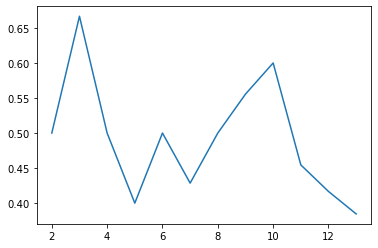

In [71]:
#plt.plot([i+2 for i in range(12)], victors)

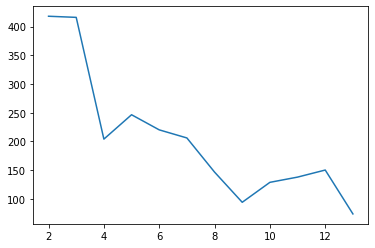

In [72]:
#plt.plot([i+2 for i in range(12)],std)

In [73]:
# I think use n_clusters as 8- but note the above may have been pretty noisy.